<a href="https://colab.research.google.com/github/FredLongo/MLDL_Project/blob/main/Final_LSTM_Team_Project_MSI_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Team Project
## By changes parameter setting you create, train and predict an array of model to predict stocks.



#Code Section

In [12]:
pip install pandas_ta

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import warnings
from datetime import datetime, timedelta


"""#Now build the model"""
from re import VERBOSE
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

""" performance evaluation """
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math
import csv
pd.set_option('display.max_columns', None)




In [14]:
class MyLSTMModel:
    def __init__(self, indicators='^DJI',
                 ticker='ADM',
                 frame_days=10,
                 lstm_layers = 1,
                 start_date = '2012-03-11',
                 end_date='2022-07-10',
                 batch_size=15,
                 epochs=30,
                 run = False,
                 run_all=False,
                 verbose=1,
                 name=''):
        #Parameters
        self.name           = name
        self.indicators     = indicators
        self.ticker         = ticker
        self.run            = run
        self.run_all        = run_all
        #Data Setup
        self.start_date     = start_date
        self.end_date       = end_date
        self.frame_days     = frame_days
        self.ticker_list    = indicators + ',' +ticker
        self.ticker_list_ct  = len(self.ticker_list.split(','))
        self.tickers        = self.ticker_list.split(',')
        self.data = pd.DataFrame()
        #Model Setup
        self.model          = None
        self.lstm_layers    = lstm_layers
        self.lstm_nodes     = 0
        self.batch_size     = batch_size
        self.epochs         = epochs
        self.verbose        = verbose
        #Report
        self.pred_diff    = np.array([])
        self.pred_diff_bias  = np.array([])
        self.pred_correctness = np.array([])
        self.pred_correctness_mean = np.array([])
        self.history = np.array([])
        self.fitting_elapse_time = None
        self.root_mean_sqr_err = None
        #Misc
        self.data_set = pd.DataFrame()
        self.data_set_scaled = np.array([])
        self.X        = np.array([])              # X[Column][Sample][Frame_day]
        self.X_train  = np.array([])
        self.X_test   = np.array([])
        self.y_train  = np.array([])
        self.y_test   = np.array([])
        self.y_pred   = np.array([])

        if self.name == '':
          self.name = ticker + '_F' + str(frame_days) + '_L' + str(lstm_layers)

        if self.run or self.run_all:
          self.Run()



    def Data__LoadAndPrep(self):
        #Download Data from Yahoo Finance
        self.data = yf.download(tickers=self.tickers, start=self.start_date, end=self.end_date)

        # Add all additional indicators
        for (_type, _ticker) in self.data.columns:
          if _type == 'Close':
            rsi_values = ta.rsi(self.data[(_type, _ticker)], length=15)
            self.data[('RSI', _ticker)] = rsi_values
            emaf_values = ta.rsi(self.data[(_type, _ticker)], length=20)
            self.data[('EMAF', _ticker)] = rsi_values
            emam_values = ta.rsi(self.data[(_type, _ticker)], length=100)
            self.data[('EMAM', _ticker)] = rsi_values
            emas_values = ta.rsi(self.data[(_type, _ticker)], length=150)
            self.data[('EMAS', _ticker)] = rsi_values

        # Add the Training an validation column info.
        self.data[('Target',self.ticker)] = self.data['Adj Close',self.ticker]-self.data['Open',self.ticker]                                # 1) Diff of current open and future close
        self.data[('Target',self.ticker)] = self.data['Target',self.ticker].shift(-1)                                                       #
        self.data[('TargetClass',self.ticker)] = [1 if self.data[('Target',self.ticker)][i]>0 else 0 for i in range(len(self.data))]        # 2) Classificaton approche 1= up 0 = down.
        self.data[('TargetNextClose',self.ticker)] = self.data[('Adj Close',self.ticker)].shift(-1)                                         # 3) Closing Price of the next day

        #Remove unused columns
        self.data.dropna(inplace=True)                                                       # Dropping values not their
        self.data.reset_index(inplace = True)                                                # rebuild index after removed values

        with warnings.catch_warnings():
          warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)
          self.data.drop([('Close', self.ticker)], axis=1, inplace=True)                       # Removing because we are going with Adjuested Close
          self.data.drop(['Date'], axis=1, inplace=True)                                       # Removing unsued Columns  (R1)


    def Data_Set__LoadAndPrep(self):
        self.data_set = self.data.iloc[:,0:len(self.data.columns)]#.values
        # Scale the dataset
        sc = MinMaxScaler(feature_range=(0,1))             # Apply Scaler to oour data to make it between 0 and `
        self.data_set_scaled = sc.fit_transform(self.data_set)


    def Data_Prep_Input(self):
        # Create frame of given candles
        self.X = []

        for j in range(len(self.data_set.columns) -1):#data_set_scaled[0].size):#2 columns are target not X         # Removing some of the columns  Adding volume
            self.X.append([])
            for i in range(self.frame_days, self.data_set_scaled.shape[0]):#framedays+2
                self.X[j].append(self.data_set_scaled[i-self.frame_days:i, j])

        #Swith Order, move axis from 0 to last position 2                               # Moves  X[Column][Sample][Frame_day]
                                                                                        #   to   X[Sample][Frame_day][Column]
        self.X = np.moveaxis( self.X, [0], [2])


        # Choose -1 for last column, classification else -2...
        self.X, yi =np.array(self.X), np.array(self.data_set_scaled[self.frame_days:,-1])
        y=np.reshape(yi,(len(yi),1))

        # split data into train test sets
        splitlimit = int(len(self.X)*0.8)          #point to slit at
        self.X_train, self.X_test = self.X[:splitlimit], self.X[splitlimit:]
        self.y_train, self.y_test = y[:splitlimit], y[splitlimit:]

        ############################################################
        ##   Build Model
        ############################################################
    def Build_Model(self):
        self.lstm_nodes = len(self.X[0][0])
        lstm_input = Input(shape=(self.frame_days, self.lstm_nodes), name='lstm_input')      # Input layer
        current_inputs = lstm_input  # first time needs to be input layer (lstm_input) after that (inputs)
        for l in reversed(range(self.lstm_layers)):
          layer_name = f'lstm_layer_{self.lstm_layers - l}'
          if 0 != l:
            inputs = LSTM(self.lstm_nodes, return_sequences=True, name=layer_name)(current_inputs)
          else:
            inputs = LSTM(self.lstm_nodes, name=layer_name)(current_inputs)
          current_inputs = inputs
        inputs = Dense(1, name='dense_layer')(inputs)                                          # One Dense Layer
        output = Activation('linear', name='output')(inputs)                                   # Output layer
        self.model = Model(inputs=lstm_input, outputs=output)                                  # declare model
        adam = optimizers.Adam()                                                               # instanciate optimizer
        self.model.compile(optimizer=adam, loss='mse', metrics=['mae'])
#        print(f'Model Layers:')                      # Compile model
#        for ml in self.model.layers:
#            print(ml.name)

    def Fit(self):
        start_time = datetime.now()
        print(f'___________{self.name}___________')
        print(f'Start Time:{start_time}')
        self.history = self.model.fit(x=self.X_train,
                       y=self.y_train,
                       batch_size=self.batch_size,
                       epochs=self.epochs, #TODO Set back to 30
                       shuffle=False,
                       validation_data=(self.X_test, self.y_test),
                       verbose=self.verbose)
        end_time = datetime.now()
        self.fitting_elapse_time = end_time - start_time
        print(f'End Time:{end_time}')
        print(f'Elapse Time:{self.fitting_elapse_time}')


    def Predict(self):
      self.y_pred = self.model.predict(self.X_test)

        ############################################################
        ### Evaluation and reports
        ############################################################
    def check_sign(self,number):
        if number > 0:
            return 1
        elif number < 0:
            return -1
        else:
            return 0


    def calculate_aic(self,y_true, y_pred,n_params):

        mse = mean_squared_error(y_true, y_pred)
        n = len(y_true)
        aic = n * np.log(mse) + 2 * n_params
        return aic



     # X_test = Open,	High,	Low,	Adj Close,	Volume,	RSI	EMAF,	EMAM,	EMAS,

    def Get_diffs(self):
        _size = self.y_test.shape[0]
        self.pred_correctness   = np.zeros(_size)
        self.pred_diff          = np.zeros(_size)
        self.pred_diff_bias      = np.zeros(_size)

        for i in range(_size):                                 # X[Sample][Frame_day][column]
          Opening    =  self.X_test[i][0][(self.ticker_list_ct * 4) -1]                        # Opening column for ticker is always (ticker_count * 4 -1)
          Actual     =  self.y_test[i]
          Predicted  =  self.y_pred[i]
          with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=DeprecationWarning)
            self.pred_diff[i]    = Predicted/Actual
            self.pred_diff_bias[i]  = 1 - (Predicted/Actual)
            if self.check_sign(Opening - Actual) == self.check_sign(Opening - Predicted):
              self.pred_correctness[i] = True;                                  #It predicted Correct!
            else: self.pred_correctness[i] = False;                             #It did predict correctly


                #Mean Squre Error
        self.mean_sqr_err =  mean_squared_error(self.y_test, self.y_pred)

        # Mean absolute Error
        self.mean_abs_err = mean_absolute_error(self.y_test, self.y_pred)

        self.pred_correctness_mean = self.pred_correctness.mean()
        self.pred_diff_mean = self.pred_diff.mean()
        self.pred_diff_bias_mean  = self.pred_diff_bias.mean()

        #AIC
        self.aic = self.calculate_aic(self.y_test,self.y_pred,self.lstm_nodes)




         # R^2    = ?????


    def View_Performance_Report(self,show_graphs=True, show_report=True , graphs=[]):


        # Root Mean Squred Error.
        self.root_mean_sqr_err = math.sqrt(self.mean_sqr_err)
        print("############################################################################")
        print("  Model Setup:")
        print(f"                    Name: {self.name}")
        print(f"             LSTM_Layers: {self.lstm_layers}")
        print(f"              LSTM_Nodes: {self.lstm_nodes}")
        print(f"               Bach_Size: {self.batch_size}")
        print(f"                  Epochs: {self.epochs}")
        print("  Data Setup:")
        print(f"                  Ticker: {self.ticker}")
        print(f"             Indicattors: {self.indicators}")
        print(f"              Start_Date: {self.start_date}")
        print(f"                End_Date: {self.end_date}")
        print(f"              Frame_Days: {self.frame_days}")
        print("  Result Data:")
        print(f'             mean_abs_err ={self.mean_abs_err}')
        print(f'             mean_sqr_err ={self.mean_sqr_err}')
        print(f'        root_mean_sqr_err ={self.root_mean_sqr_err}')
        print(f'           pred_diff_mean ={self.pred_diff_mean}')
        print(f'      pred_diff_bias_mean ={self.pred_diff_bias_mean}')
        print(f'    pred_correctness_mean ={self.pred_correctness_mean}')
        print(f'                      AIC ={self.aic}')

        print("")

        #Plot Graph



        if  ('Eval_Loss' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)

          plt.figure(figsize=(12, 6))
          plt.subplot(1, 2, 1)
          plt.plot(self.history.history['mae'])
          plt.plot(self.history.history['val_mae'])
          plt.title('Evaluation Metric - Mean Absolute Error (MAE)')
          plt.ylabel('MAE')
          plt.xlabel('Epoch')
          plt.legend(['Train', 'Validation'], loc='upper left')


          # Plot training & validation loss values
          plt.subplot(1, 2, 2)
          plt.plot(self.history.history['loss'])
          plt.plot(self.history.history['val_loss'])
          plt.title('Model Loss - Mean Sqr Error (MSE) ')
          plt.ylabel('Loss')
          plt.xlabel('Epoch')
          plt.legend(['Train', 'Validation'], loc='upper left')
          plt.show()

        if  ('TrainingMAE' in graphs) or (show_graphs == True) :
          #####Break Down
          plt.figure(figsize=(12, 6))

          #plt.subplot(1, 1, 1)
          plt.plot(self.history.history['mae'])
          plt.title('Training Mean Absolute Error')
          plt.ylabel('MAE')
          plt.xlabel('Epoch')
          plt.legend(['Train'], loc='upper left')
          plt.show()


        if  ('ActVsPed_Line' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)
          # Actual vs Predicted Chart
          plt.figure(figsize=(16,8))
          plt.title('Actual Vs Prediction Results')
          plt.plot(self.y_test, color = 'black', label = 'Test')
          plt.plot(self.y_pred, color = 'green', label = 'pred')
          plt.legend()
          plt.show()

        if  ('ActVsPed_Pie' in graphs) or (show_graphs == True) :  # ('Pie' in show_graphs:)
          # Pie Chart
          values = [self.pred_correctness_mean, 1 - self.pred_correctness_mean ]
          labels = [f'Correctly Predicted {self.pred_correctness_mean:.2f}%', f'Incorrect{1 - self.pred_correctness_mean:.2f}%']
          colors = ['g','r']
          explode = [0.1, 0]
          plt.title(f'Correct Prediction " {self.pred_correctness_mean:.2f}%  "of the time')
          plt.pie(values, labels=labels, colors=colors, explode=explode)
          plt.show




    def Run(self):
      self.Data__LoadAndPrep()
      self.Data_Set__LoadAndPrep()
      self.Data_Prep_Input()
      self.Build_Model()
      self.Fit()
      self.Predict()
      self.Get_diffs()
      if self.run_all == True:
        self.View_Performance_Report()









In [15]:
def SaveDataToCSV(_model_list,_ticker_symble):
  # Specify the CSV file name
  current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
  filename = f'/content/drive/MyDrive/Classes/Kent/Machine Learning/Results/{_ticker_symble}_Results_{current_datetime}.csv'

  # Field names in the CSV file
  fields = ['ModelName','Layers','Batch_Size', 'Epoch','Ticker','Indicators','Frame_Days','mean_abs_err','mean_sqr_err','root_mean_sqr_err','pred_diff_mean','pred_diff_bias_mean','elapsTime','pred_correctness_mean','AIC']

  # Writing to the csv file
  with open(filename, mode='w', newline='') as file:
      writer = csv.DictWriter(file, fieldnames=fields)

      # Writing headers (field names)
      writer.writeheader()

      # Writing data of each object
      for m in _model_list:
          writer.writerow({'ModelName': m.name,
                           'Layers':m.lstm_layers,
                           'Batch_Size': m.batch_size,
                           'Epoch':m.epochs,
                           'Ticker':m.ticker,
                           'Indicators':m.indicators,
                           'Frame_Days':m.frame_days,
                           'mean_abs_err':m.mean_abs_err,
                           'mean_sqr_err':m.mean_sqr_err,
                           'root_mean_sqr_err':m.root_mean_sqr_err,
                           'pred_diff_mean':m.pred_diff_mean,
                           'pred_diff_bias_mean':m.pred_diff_bias_mean,
                           "elapsTime":m.fitting_elapse_time,
                           "pred_correctness_mean":m.pred_correctness_mean,
                           "AIC":m.aic
                            })


# Get Fields








# Model Fit Section

# Model Training

In [16]:
Indicators    = '^DJI,^BSESN,^BVSP'
#Ticker = ['ADM','MSI','XOM']
#frame_days = [10,25,50,75,100]
#LSTM_layers = [1,2,3,4,5]


#AMD
#Ticker = ['ADM']
#frame_days = [10,25,50,75,100]
#LSTM_layers = [1,2,3,4,5]

#MSI
Ticker = ['MSI']
frame_days = [10,25,50]
LSTM_layers = [1,2,3,4,5]

#XOM
#Ticker = ['XOM']
#frame_days = [10,25,50,75,100]
#LSTM_layers = [1,2,3,4,5]



Number_of_Models_to_Test = len(Ticker) * len(frame_days) *  len(LSTM_layers)

print(f'Testing {Number_of_Models_to_Test} models')


Testing 15 models


In [17]:


for t in Ticker:
  model_list = []
  for f in frame_days:
    for l in LSTM_layers:
      new_model = MyLSTMModel(indicators= Indicators,
                              ticker=t,
                              frame_days=f,
                              lstm_layers=l,
                              verbose=2,
                              run=True)
      model_list.append(new_model)

  #Best_Model = max(model_list, key=lambda m:m.pred_diff_mean)
  #print(f"Best Model is {Best_Model.name} with {Best_Model.pred_diff_mean:.2f}%  !!!")
  SaveDataToCSV(model_list,t)



[*********************100%%**********************]  4 of 4 completed


___________MSI_F10_L1___________
Start Time:2024-05-01 01:24:31.202857
Epoch 1/30
122/122 - 10s - loss: 0.0048 - mae: 0.0496 - val_loss: 0.0290 - val_mae: 0.1412 - 10s/epoch - 80ms/step
Epoch 2/30
122/122 - 2s - loss: 0.0015 - mae: 0.0317 - val_loss: 0.0217 - val_mae: 0.1167 - 2s/epoch - 16ms/step
Epoch 3/30
122/122 - 2s - loss: 0.0011 - mae: 0.0261 - val_loss: 0.0262 - val_mae: 0.1306 - 2s/epoch - 16ms/step
Epoch 4/30
122/122 - 2s - loss: 8.0524e-04 - mae: 0.0228 - val_loss: 0.0260 - val_mae: 0.1290 - 2s/epoch - 17ms/step
Epoch 5/30
122/122 - 2s - loss: 7.5410e-04 - mae: 0.0219 - val_loss: 0.0279 - val_mae: 0.1339 - 2s/epoch - 17ms/step
Epoch 6/30
122/122 - 2s - loss: 7.6456e-04 - mae: 0.0215 - val_loss: 0.0312 - val_mae: 0.1427 - 2s/epoch - 14ms/step
Epoch 7/30
122/122 - 2s - loss: 8.7919e-04 - mae: 0.0229 - val_loss: 0.0390 - val_mae: 0.1618 - 2s/epoch - 16ms/step
Epoch 8/30
122/122 - 2s - loss: 0.0011 - mae: 0.0266 - val_loss: 0.0591 - val_mae: 0.2087 - 2s/epoch - 14ms/step
Epoch 9

[*********************100%%**********************]  4 of 4 completed


___________MSI_F10_L2___________
Start Time:2024-05-01 01:25:24.105438
Epoch 1/30
122/122 - 8s - loss: 0.0016 - mae: 0.0309 - val_loss: 0.0913 - val_mae: 0.2585 - 8s/epoch - 63ms/step
Epoch 2/30
122/122 - 1s - loss: 0.0024 - mae: 0.0350 - val_loss: 0.0609 - val_mae: 0.2048 - 1s/epoch - 12ms/step
Epoch 3/30
122/122 - 2s - loss: 0.0022 - mae: 0.0299 - val_loss: 0.1487 - val_mae: 0.3469 - 2s/epoch - 13ms/step
Epoch 4/30
122/122 - 1s - loss: 0.0031 - mae: 0.0366 - val_loss: 0.0805 - val_mae: 0.2421 - 1s/epoch - 12ms/step
Epoch 5/30
122/122 - 1s - loss: 0.0034 - mae: 0.0399 - val_loss: 0.0456 - val_mae: 0.1752 - 1s/epoch - 12ms/step
Epoch 6/30
122/122 - 1s - loss: 0.0031 - mae: 0.0398 - val_loss: 0.0570 - val_mae: 0.1999 - 1s/epoch - 12ms/step
Epoch 7/30
122/122 - 1s - loss: 0.0030 - mae: 0.0390 - val_loss: 0.0574 - val_mae: 0.2041 - 1s/epoch - 12ms/step
Epoch 8/30
122/122 - 2s - loss: 0.0022 - mae: 0.0358 - val_loss: 0.0560 - val_mae: 0.2029 - 2s/epoch - 17ms/step
Epoch 9/30
122/122 - 2s -

[*********************100%%**********************]  4 of 4 completed


___________MSI_F10_L3___________
Start Time:2024-05-01 01:26:21.910396
Epoch 1/30
122/122 - 12s - loss: 9.9980e-04 - mae: 0.0250 - val_loss: 0.0736 - val_mae: 0.2324 - 12s/epoch - 95ms/step
Epoch 2/30
122/122 - 2s - loss: 0.0024 - mae: 0.0304 - val_loss: 0.1217 - val_mae: 0.3146 - 2s/epoch - 18ms/step
Epoch 3/30
122/122 - 3s - loss: 0.0021 - mae: 0.0299 - val_loss: 0.1287 - val_mae: 0.3220 - 3s/epoch - 23ms/step
Epoch 4/30
122/122 - 3s - loss: 0.0027 - mae: 0.0308 - val_loss: 0.1324 - val_mae: 0.3317 - 3s/epoch - 22ms/step
Epoch 5/30
122/122 - 2s - loss: 0.0026 - mae: 0.0347 - val_loss: 0.1315 - val_mae: 0.3281 - 2s/epoch - 18ms/step
Epoch 6/30
122/122 - 2s - loss: 0.0035 - mae: 0.0404 - val_loss: 0.0649 - val_mae: 0.2138 - 2s/epoch - 18ms/step
Epoch 7/30
122/122 - 2s - loss: 0.0048 - mae: 0.0455 - val_loss: 0.0775 - val_mae: 0.2335 - 2s/epoch - 18ms/step
Epoch 8/30
122/122 - 2s - loss: 0.0047 - mae: 0.0415 - val_loss: 0.0737 - val_mae: 0.2287 - 2s/epoch - 17ms/step
Epoch 9/30
122/122 

[*********************100%%**********************]  4 of 4 completed


___________MSI_F10_L4___________
Start Time:2024-05-01 01:27:53.992830
Epoch 1/30
122/122 - 15s - loss: 9.2382e-04 - mae: 0.0226 - val_loss: 0.1108 - val_mae: 0.2954 - 15s/epoch - 121ms/step
Epoch 2/30
122/122 - 3s - loss: 0.0031 - mae: 0.0330 - val_loss: 0.1313 - val_mae: 0.3275 - 3s/epoch - 23ms/step
Epoch 3/30
122/122 - 4s - loss: 0.0027 - mae: 0.0332 - val_loss: 0.1620 - val_mae: 0.3695 - 4s/epoch - 29ms/step
Epoch 4/30
122/122 - 3s - loss: 0.0032 - mae: 0.0379 - val_loss: 0.1573 - val_mae: 0.3624 - 3s/epoch - 22ms/step
Epoch 5/30
122/122 - 3s - loss: 0.0032 - mae: 0.0369 - val_loss: 0.1213 - val_mae: 0.3109 - 3s/epoch - 22ms/step
Epoch 6/30
122/122 - 3s - loss: 0.0037 - mae: 0.0405 - val_loss: 0.1100 - val_mae: 0.2941 - 3s/epoch - 22ms/step
Epoch 7/30
122/122 - 3s - loss: 0.0048 - mae: 0.0494 - val_loss: 0.0889 - val_mae: 0.2570 - 3s/epoch - 24ms/step
Epoch 8/30
122/122 - 3s - loss: 0.0087 - mae: 0.0644 - val_loss: 0.0843 - val_mae: 0.2492 - 3s/epoch - 26ms/step
Epoch 9/30
122/122

[*********************100%%**********************]  4 of 4 completed


___________MSI_F10_L5___________
Start Time:2024-05-01 01:30:29.170769
Epoch 1/30
122/122 - 16s - loss: 9.3368e-04 - mae: 0.0222 - val_loss: 0.1241 - val_mae: 0.3150 - 16s/epoch - 127ms/step
Epoch 2/30
122/122 - 3s - loss: 0.0039 - mae: 0.0358 - val_loss: 0.1748 - val_mae: 0.3870 - 3s/epoch - 26ms/step
Epoch 3/30
122/122 - 4s - loss: 0.0030 - mae: 0.0362 - val_loss: 0.1487 - val_mae: 0.3513 - 4s/epoch - 34ms/step
Epoch 4/30
122/122 - 3s - loss: 0.0037 - mae: 0.0394 - val_loss: 0.1473 - val_mae: 0.3500 - 3s/epoch - 28ms/step
Epoch 5/30
122/122 - 3s - loss: 0.0039 - mae: 0.0404 - val_loss: 0.1403 - val_mae: 0.3398 - 3s/epoch - 26ms/step
Epoch 6/30
122/122 - 3s - loss: 0.0047 - mae: 0.0466 - val_loss: 0.0783 - val_mae: 0.2374 - 3s/epoch - 25ms/step
Epoch 7/30
122/122 - 5s - loss: 0.0084 - mae: 0.0625 - val_loss: 0.1060 - val_mae: 0.2859 - 5s/epoch - 38ms/step
Epoch 8/30
122/122 - 4s - loss: 0.0126 - mae: 0.0829 - val_loss: 0.1040 - val_mae: 0.2826 - 4s/epoch - 37ms/step
Epoch 9/30
122/122

[*********************100%%**********************]  4 of 4 completed


___________MSI_F25_L1___________
Start Time:2024-05-01 01:32:30.594620
Epoch 1/30
121/121 - 5s - loss: 0.0034 - mae: 0.0455 - val_loss: 0.0737 - val_mae: 0.2332 - 5s/epoch - 44ms/step
Epoch 2/30
121/121 - 1s - loss: 0.0048 - mae: 0.0541 - val_loss: 0.0548 - val_mae: 0.1967 - 1s/epoch - 12ms/step
Epoch 3/30
121/121 - 1s - loss: 0.0038 - mae: 0.0444 - val_loss: 0.0767 - val_mae: 0.2524 - 1s/epoch - 12ms/step
Epoch 4/30
121/121 - 1s - loss: 0.0012 - mae: 0.0260 - val_loss: 0.0740 - val_mae: 0.2444 - 1s/epoch - 12ms/step
Epoch 5/30
121/121 - 1s - loss: 0.0011 - mae: 0.0246 - val_loss: 0.0754 - val_mae: 0.2426 - 1s/epoch - 12ms/step
Epoch 6/30
121/121 - 1s - loss: 0.0014 - mae: 0.0281 - val_loss: 0.0705 - val_mae: 0.2289 - 1s/epoch - 12ms/step
Epoch 7/30
121/121 - 2s - loss: 0.0019 - mae: 0.0324 - val_loss: 0.0581 - val_mae: 0.2029 - 2s/epoch - 15ms/step
Epoch 8/30
121/121 - 2s - loss: 0.0024 - mae: 0.0370 - val_loss: 0.0466 - val_mae: 0.1799 - 2s/epoch - 17ms/step
Epoch 9/30
121/121 - 2s -

[*********************100%%**********************]  4 of 4 completed


___________MSI_F25_L2___________
Start Time:2024-05-01 01:33:57.374044
Epoch 1/30
121/121 - 9s - loss: 0.0022 - mae: 0.0374 - val_loss: 0.0487 - val_mae: 0.1799 - 9s/epoch - 71ms/step
Epoch 2/30
121/121 - 3s - loss: 0.0030 - mae: 0.0405 - val_loss: 0.0722 - val_mae: 0.2286 - 3s/epoch - 23ms/step
Epoch 3/30
121/121 - 3s - loss: 0.0039 - mae: 0.0400 - val_loss: 0.0591 - val_mae: 0.2039 - 3s/epoch - 23ms/step
Epoch 4/30
121/121 - 3s - loss: 0.0032 - mae: 0.0383 - val_loss: 0.0837 - val_mae: 0.2564 - 3s/epoch - 23ms/step
Epoch 5/30
121/121 - 3s - loss: 0.0025 - mae: 0.0381 - val_loss: 0.0705 - val_mae: 0.2310 - 3s/epoch - 27ms/step
Epoch 6/30
121/121 - 3s - loss: 0.0022 - mae: 0.0365 - val_loss: 0.0731 - val_mae: 0.2347 - 3s/epoch - 27ms/step
Epoch 7/30
121/121 - 3s - loss: 0.0020 - mae: 0.0352 - val_loss: 0.0689 - val_mae: 0.2257 - 3s/epoch - 23ms/step
Epoch 8/30
121/121 - 3s - loss: 0.0019 - mae: 0.0351 - val_loss: 0.0636 - val_mae: 0.2131 - 3s/epoch - 23ms/step
Epoch 9/30
121/121 - 3s -

[*********************100%%**********************]  4 of 4 completed


___________MSI_F25_L3___________
Start Time:2024-05-01 01:36:25.066134
Epoch 1/30
121/121 - 12s - loss: 0.0012 - mae: 0.0271 - val_loss: 0.0993 - val_mae: 0.2772 - 12s/epoch - 98ms/step
Epoch 2/30
121/121 - 4s - loss: 0.0025 - mae: 0.0304 - val_loss: 0.1604 - val_mae: 0.3701 - 4s/epoch - 32ms/step
Epoch 3/30
121/121 - 5s - loss: 0.0020 - mae: 0.0305 - val_loss: 0.1237 - val_mae: 0.3168 - 5s/epoch - 38ms/step
Epoch 4/30
121/121 - 4s - loss: 0.0024 - mae: 0.0317 - val_loss: 0.1424 - val_mae: 0.3431 - 4s/epoch - 36ms/step
Epoch 5/30
121/121 - 4s - loss: 0.0028 - mae: 0.0328 - val_loss: 0.1485 - val_mae: 0.3496 - 4s/epoch - 32ms/step
Epoch 6/30
121/121 - 4s - loss: 0.0028 - mae: 0.0341 - val_loss: 0.1436 - val_mae: 0.3461 - 4s/epoch - 32ms/step
Epoch 7/30
121/121 - 5s - loss: 0.0028 - mae: 0.0327 - val_loss: 0.1412 - val_mae: 0.3416 - 5s/epoch - 40ms/step
Epoch 8/30
121/121 - 4s - loss: 0.0032 - mae: 0.0375 - val_loss: 0.0916 - val_mae: 0.2646 - 4s/epoch - 32ms/step
Epoch 9/30
121/121 - 4s

[*********************100%%**********************]  4 of 4 completed


___________MSI_F25_L4___________
Start Time:2024-05-01 01:38:45.678241
Epoch 1/30
121/121 - 15s - loss: 0.0014 - mae: 0.0268 - val_loss: 0.1398 - val_mae: 0.3375 - 15s/epoch - 125ms/step
Epoch 2/30
121/121 - 6s - loss: 0.0031 - mae: 0.0350 - val_loss: 0.1545 - val_mae: 0.3612 - 6s/epoch - 49ms/step
Epoch 3/30
121/121 - 6s - loss: 0.0026 - mae: 0.0325 - val_loss: 0.2019 - val_mae: 0.4186 - 6s/epoch - 46ms/step
Epoch 4/30
121/121 - 5s - loss: 0.0024 - mae: 0.0295 - val_loss: 0.1501 - val_mae: 0.3541 - 5s/epoch - 44ms/step
Epoch 5/30
121/121 - 6s - loss: 0.0032 - mae: 0.0370 - val_loss: 0.1556 - val_mae: 0.3609 - 6s/epoch - 54ms/step
Epoch 6/30
121/121 - 5s - loss: 0.0032 - mae: 0.0351 - val_loss: 0.1561 - val_mae: 0.3611 - 5s/epoch - 44ms/step
Epoch 7/30
121/121 - 7s - loss: 0.0035 - mae: 0.0373 - val_loss: 0.1305 - val_mae: 0.3252 - 7s/epoch - 54ms/step
Epoch 8/30
121/121 - 5s - loss: 0.0034 - mae: 0.0361 - val_loss: 0.1654 - val_mae: 0.3733 - 5s/epoch - 44ms/step
Epoch 9/30
121/121 - 6

[*********************100%%**********************]  4 of 4 completed


___________MSI_F25_L5___________
Start Time:2024-05-01 01:42:19.641905
Epoch 1/30
121/121 - 21s - loss: 0.0013 - mae: 0.0246 - val_loss: 0.1731 - val_mae: 0.3845 - 21s/epoch - 171ms/step
Epoch 2/30
121/121 - 8s - loss: 0.0026 - mae: 0.0313 - val_loss: 0.1862 - val_mae: 0.3981 - 8s/epoch - 64ms/step
Epoch 3/30
121/121 - 6s - loss: 0.0033 - mae: 0.0354 - val_loss: 0.1683 - val_mae: 0.3776 - 6s/epoch - 53ms/step
Epoch 4/30
121/121 - 9s - loss: 0.0033 - mae: 0.0365 - val_loss: 0.1653 - val_mae: 0.3731 - 9s/epoch - 76ms/step
Epoch 5/30
121/121 - 6s - loss: 0.0032 - mae: 0.0343 - val_loss: 0.1712 - val_mae: 0.3794 - 6s/epoch - 53ms/step
Epoch 6/30
121/121 - 8s - loss: 0.0035 - mae: 0.0374 - val_loss: 0.1509 - val_mae: 0.3552 - 8s/epoch - 63ms/step
Epoch 7/30
121/121 - 6s - loss: 0.0034 - mae: 0.0356 - val_loss: 0.1407 - val_mae: 0.3403 - 6s/epoch - 53ms/step
Epoch 8/30
121/121 - 8s - loss: 0.0039 - mae: 0.0401 - val_loss: 0.1609 - val_mae: 0.3685 - 8s/epoch - 63ms/step
Epoch 9/30
121/121 - 6

[*********************100%%**********************]  4 of 4 completed


___________MSI_F50_L1___________
Start Time:2024-05-01 01:46:12.038115
Epoch 1/30
120/120 - 6s - loss: 0.0051 - mae: 0.0526 - val_loss: 0.0271 - val_mae: 0.1294 - 6s/epoch - 54ms/step
Epoch 2/30
120/120 - 3s - loss: 0.0022 - mae: 0.0376 - val_loss: 0.0303 - val_mae: 0.1398 - 3s/epoch - 22ms/step
Epoch 3/30
120/120 - 3s - loss: 0.0040 - mae: 0.0477 - val_loss: 0.0539 - val_mae: 0.2038 - 3s/epoch - 22ms/step
Epoch 4/30
120/120 - 3s - loss: 0.0011 - mae: 0.0262 - val_loss: 0.0508 - val_mae: 0.1967 - 3s/epoch - 21ms/step
Epoch 5/30
120/120 - 3s - loss: 8.5097e-04 - mae: 0.0222 - val_loss: 0.0533 - val_mae: 0.2010 - 3s/epoch - 23ms/step
Epoch 6/30
120/120 - 3s - loss: 8.8489e-04 - mae: 0.0227 - val_loss: 0.0563 - val_mae: 0.2060 - 3s/epoch - 28ms/step
Epoch 7/30
120/120 - 3s - loss: 9.8080e-04 - mae: 0.0240 - val_loss: 0.0575 - val_mae: 0.2065 - 3s/epoch - 21ms/step
Epoch 8/30
120/120 - 3s - loss: 0.0012 - mae: 0.0261 - val_loss: 0.0556 - val_mae: 0.2001 - 3s/epoch - 22ms/step
Epoch 9/30
12

[*********************100%%**********************]  4 of 4 completed


___________MSI_F50_L2___________
Start Time:2024-05-01 01:48:37.886604
Epoch 1/30
120/120 - 11s - loss: 0.0016 - mae: 0.0321 - val_loss: 0.1100 - val_mae: 0.2921 - 11s/epoch - 92ms/step
Epoch 2/30
120/120 - 5s - loss: 0.0031 - mae: 0.0371 - val_loss: 0.1022 - val_mae: 0.2781 - 5s/epoch - 43ms/step
Epoch 3/30
120/120 - 6s - loss: 0.0028 - mae: 0.0331 - val_loss: 0.1275 - val_mae: 0.3185 - 6s/epoch - 50ms/step
Epoch 4/30
120/120 - 5s - loss: 0.0038 - mae: 0.0440 - val_loss: 0.0885 - val_mae: 0.2565 - 5s/epoch - 44ms/step
Epoch 5/30
120/120 - 5s - loss: 0.0041 - mae: 0.0422 - val_loss: 0.1102 - val_mae: 0.2955 - 5s/epoch - 42ms/step
Epoch 6/30
120/120 - 6s - loss: 0.0041 - mae: 0.0441 - val_loss: 0.0635 - val_mae: 0.2115 - 6s/epoch - 54ms/step
Epoch 7/30
120/120 - 5s - loss: 0.0043 - mae: 0.0436 - val_loss: 0.0573 - val_mae: 0.2001 - 5s/epoch - 41ms/step
Epoch 8/30
120/120 - 7s - loss: 0.0036 - mae: 0.0438 - val_loss: 0.0689 - val_mae: 0.2285 - 7s/epoch - 54ms/step
Epoch 9/30
120/120 - 6s

[*********************100%%**********************]  4 of 4 completed


___________MSI_F50_L3___________
Start Time:2024-05-01 01:52:06.144345
Epoch 1/30
120/120 - 19s - loss: 0.0016 - mae: 0.0303 - val_loss: 0.1312 - val_mae: 0.3288 - 19s/epoch - 162ms/step
Epoch 2/30
120/120 - 8s - loss: 0.0022 - mae: 0.0325 - val_loss: 0.1233 - val_mae: 0.3186 - 8s/epoch - 67ms/step
Epoch 3/30
120/120 - 9s - loss: 0.0027 - mae: 0.0329 - val_loss: 0.1680 - val_mae: 0.3766 - 9s/epoch - 71ms/step
Epoch 4/30
120/120 - 7s - loss: 0.0028 - mae: 0.0316 - val_loss: 0.1498 - val_mae: 0.3553 - 7s/epoch - 61ms/step
Epoch 5/30
120/120 - 9s - loss: 0.0030 - mae: 0.0375 - val_loss: 0.1291 - val_mae: 0.3270 - 9s/epoch - 72ms/step
Epoch 6/30
120/120 - 7s - loss: 0.0035 - mae: 0.0414 - val_loss: 0.1023 - val_mae: 0.2826 - 7s/epoch - 61ms/step
Epoch 7/30
120/120 - 9s - loss: 0.0032 - mae: 0.0336 - val_loss: 0.1599 - val_mae: 0.3684 - 9s/epoch - 72ms/step
Epoch 8/30
120/120 - 8s - loss: 0.0036 - mae: 0.0390 - val_loss: 0.1246 - val_mae: 0.3168 - 8s/epoch - 66ms/step
Epoch 9/30
120/120 - 8

[*********************100%%**********************]  4 of 4 completed


___________MSI_F50_L4___________
Start Time:2024-05-01 01:56:37.905053
Epoch 1/30
120/120 - 21s - loss: 0.0011 - mae: 0.0243 - val_loss: 0.1507 - val_mae: 0.3561 - 21s/epoch - 172ms/step
Epoch 2/30
120/120 - 11s - loss: 0.0026 - mae: 0.0319 - val_loss: 0.1504 - val_mae: 0.3531 - 11s/epoch - 95ms/step
Epoch 3/30
120/120 - 12s - loss: 0.0033 - mae: 0.0345 - val_loss: 0.1792 - val_mae: 0.3901 - 12s/epoch - 96ms/step
Epoch 4/30
120/120 - 9s - loss: 0.0031 - mae: 0.0337 - val_loss: 0.1787 - val_mae: 0.3939 - 9s/epoch - 79ms/step
Epoch 5/30
120/120 - 11s - loss: 0.0032 - mae: 0.0391 - val_loss: 0.1593 - val_mae: 0.3668 - 11s/epoch - 91ms/step
Epoch 6/30
120/120 - 11s - loss: 0.0031 - mae: 0.0346 - val_loss: 0.1817 - val_mae: 0.3939 - 11s/epoch - 90ms/step
Epoch 7/30
120/120 - 12s - loss: 0.0040 - mae: 0.0408 - val_loss: 0.0878 - val_mae: 0.2561 - 12s/epoch - 98ms/step
Epoch 8/30
120/120 - 10s - loss: 0.0057 - mae: 0.0405 - val_loss: 0.1768 - val_mae: 0.3865 - 10s/epoch - 83ms/step
Epoch 9/30

[*********************100%%**********************]  4 of 4 completed


___________MSI_F50_L5___________
Start Time:2024-05-01 02:02:13.586234
Epoch 1/30
120/120 - 25s - loss: 0.0011 - mae: 0.0238 - val_loss: 0.1559 - val_mae: 0.3642 - 25s/epoch - 212ms/step
Epoch 2/30
120/120 - 13s - loss: 0.0029 - mae: 0.0332 - val_loss: 0.1772 - val_mae: 0.3918 - 13s/epoch - 112ms/step
Epoch 3/30
120/120 - 14s - loss: 0.0031 - mae: 0.0361 - val_loss: 0.1803 - val_mae: 0.3954 - 14s/epoch - 113ms/step
Epoch 4/30
120/120 - 14s - loss: 0.0030 - mae: 0.0358 - val_loss: 0.1763 - val_mae: 0.3903 - 14s/epoch - 113ms/step
Epoch 5/30
120/120 - 13s - loss: 0.0032 - mae: 0.0321 - val_loss: 0.1659 - val_mae: 0.3769 - 13s/epoch - 112ms/step
Epoch 6/30
120/120 - 15s - loss: 0.0031 - mae: 0.0326 - val_loss: 0.1752 - val_mae: 0.3899 - 15s/epoch - 124ms/step
Epoch 7/30
120/120 - 13s - loss: 0.0037 - mae: 0.0412 - val_loss: 0.1230 - val_mae: 0.3155 - 13s/epoch - 112ms/step
Epoch 8/30
120/120 - 14s - loss: 0.0059 - mae: 0.0480 - val_loss: 0.0955 - val_mae: 0.2697 - 14s/epoch - 114ms/step
E

In [18]:
#SaveDataToCSV(model_list,'MSI')

# Report Section

In [19]:
for m in model_list:
  m.View_Performance_Report(show_graphs=False)




############################################################################
  Model Setup:
                    Name: MSI_F10_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.09283382694640482
             mean_sqr_err =0.012303371855429792
        root_mean_sqr_err =0.11092056552069049
           pred_diff_mean =0.9529748347865912
      pred_diff_bias_mean =0.04702516521340882
    pred_correctness_mean =0.5492341356673961
                      AIC =-1927.8320372498872

############################################################################
  Model Setup:
                    Name: MSI_F10_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
      

############################################################################
  Model Setup:
                    Name: MSI_F10_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.09283382694640482
             mean_sqr_err =0.012303371855429792
        root_mean_sqr_err =0.11092056552069049
           pred_diff_mean =0.9529748347865912
      pred_diff_bias_mean =0.04702516521340882
    pred_correctness_mean =0.5492341356673961
                      AIC =-1927.8320372498872



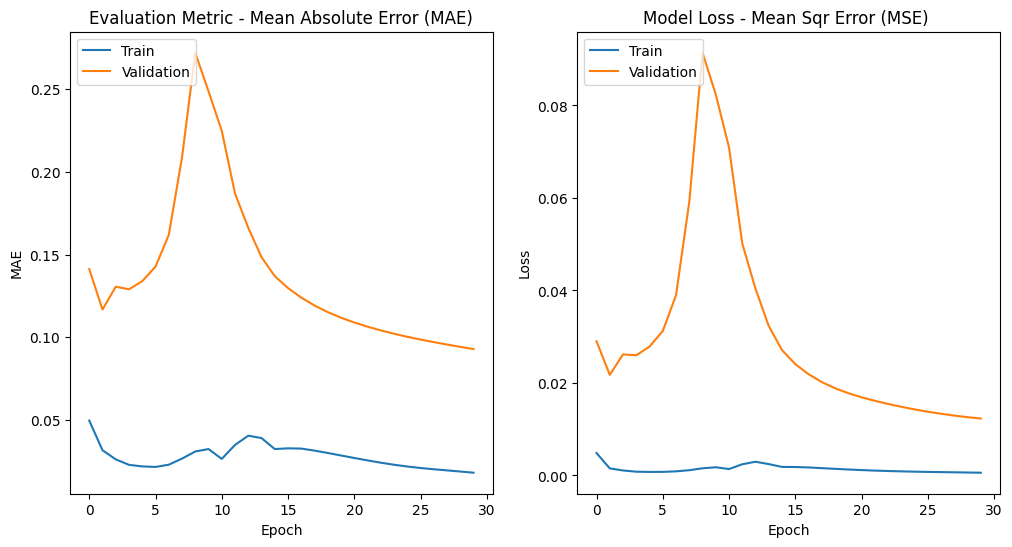

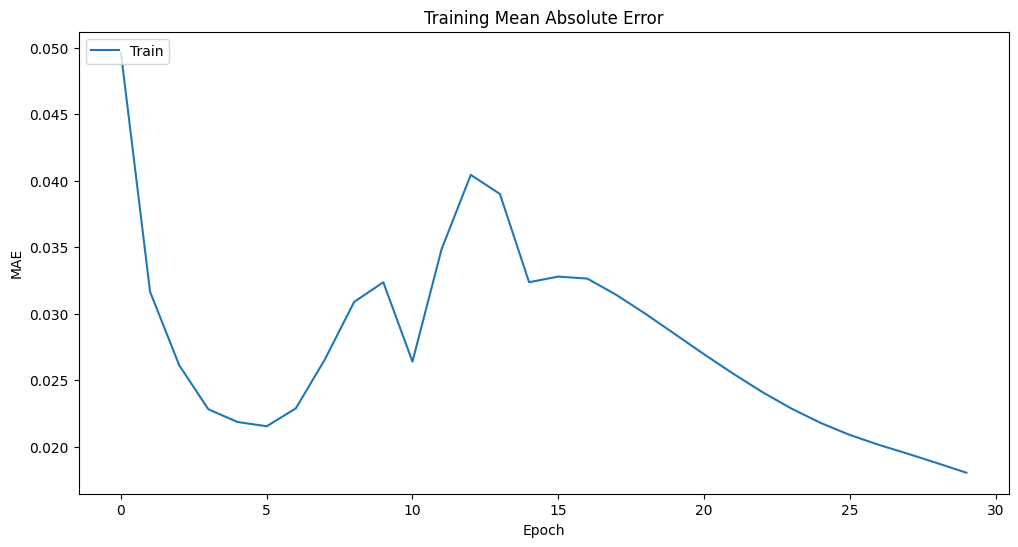

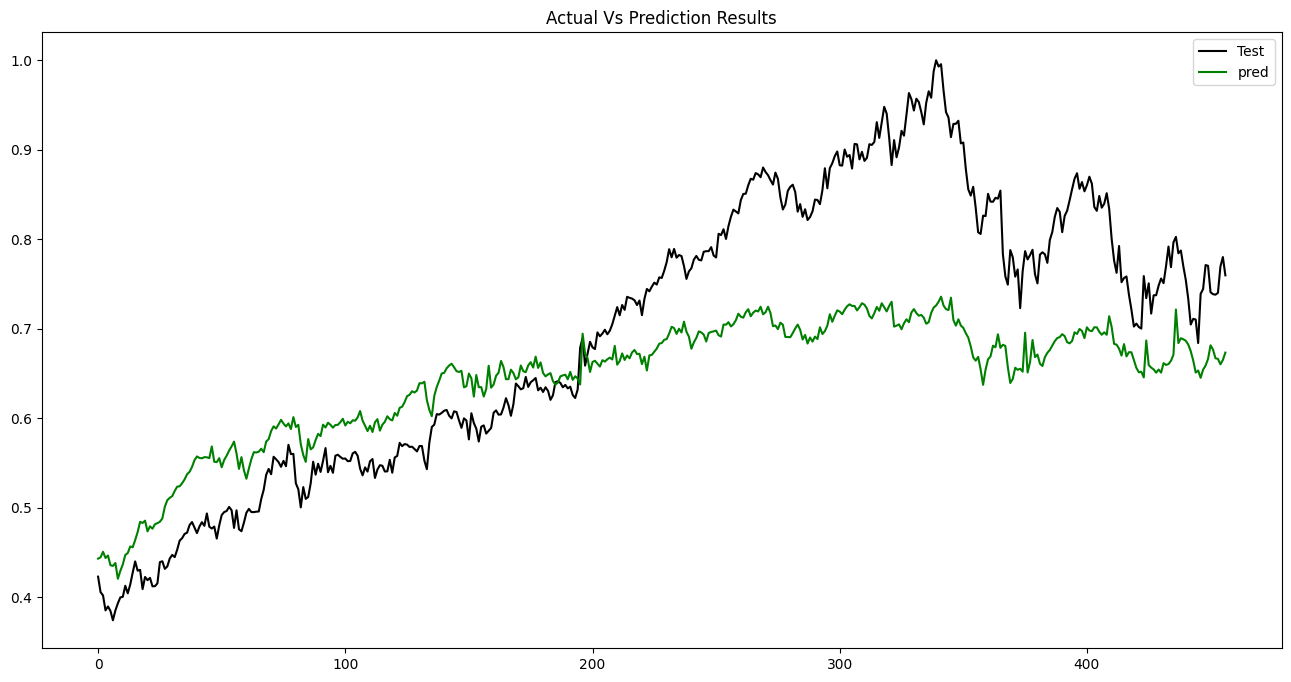

############################################################################
  Model Setup:
                    Name: MSI_F10_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.1294480006681115
             mean_sqr_err =0.025738751771327603
        root_mean_sqr_err =0.16043301334615517
           pred_diff_mean =0.8989243726347662
      pred_diff_bias_mean =0.10107562736523386
    pred_correctness_mean =0.5251641137855579
                      AIC =-1590.5092102771514



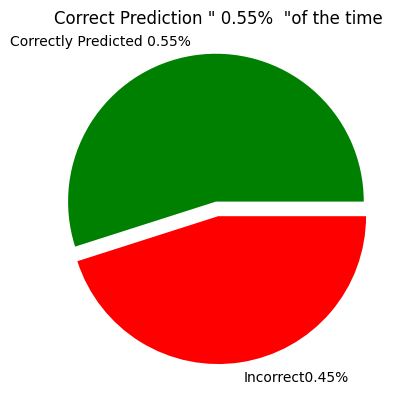

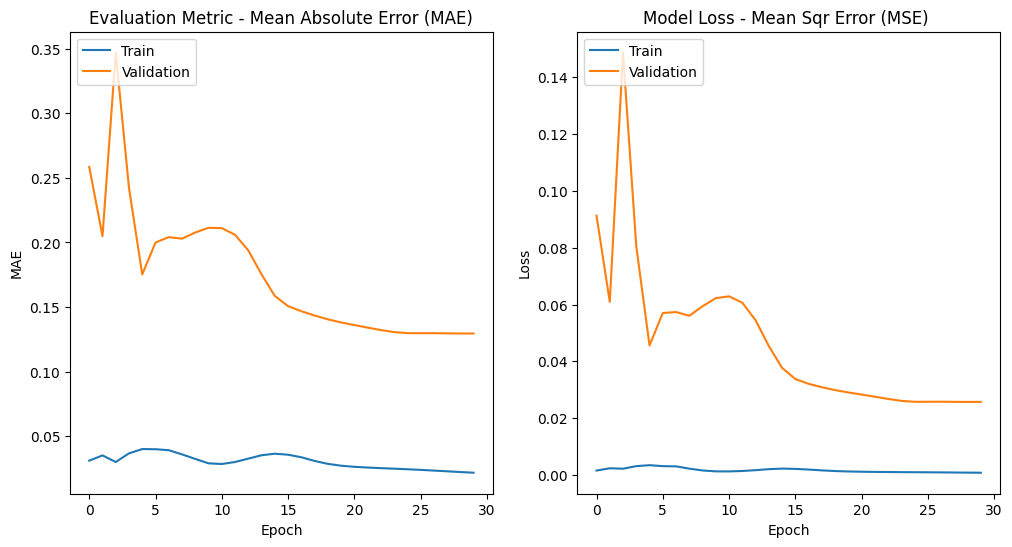

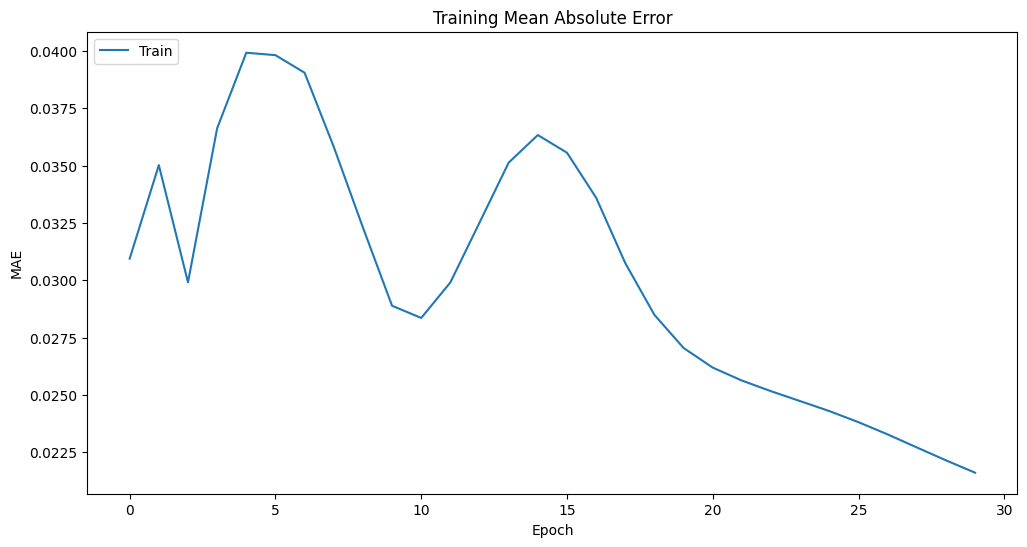

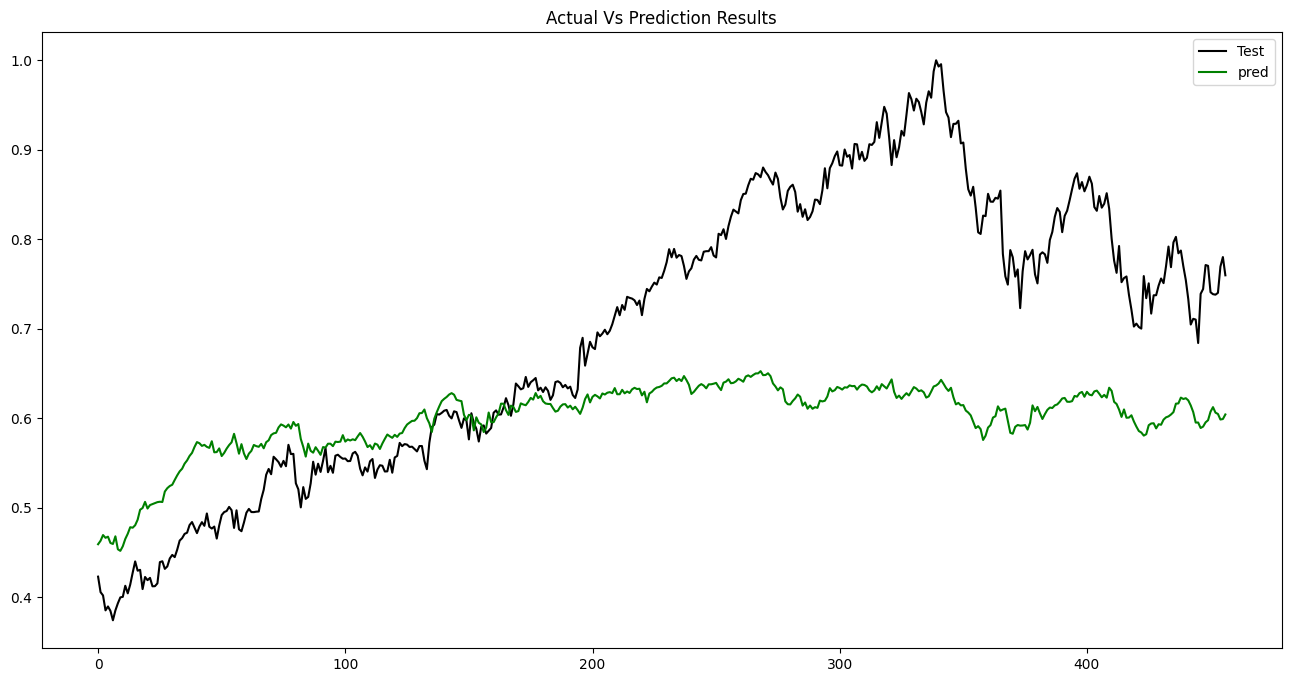

############################################################################
  Model Setup:
                    Name: MSI_F10_L3
             LSTM_Layers: 3
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.13380149491903276
             mean_sqr_err =0.028092399456453834
        root_mean_sqr_err =0.1676078740884623
           pred_diff_mean =0.8855241443634467
      pred_diff_bias_mean =0.1144758556365534
    pred_correctness_mean =0.5207877461706784
                      AIC =-1550.5210930911496



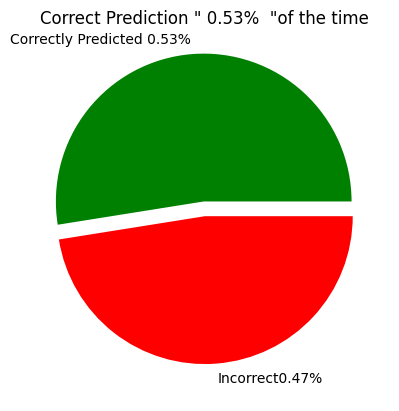

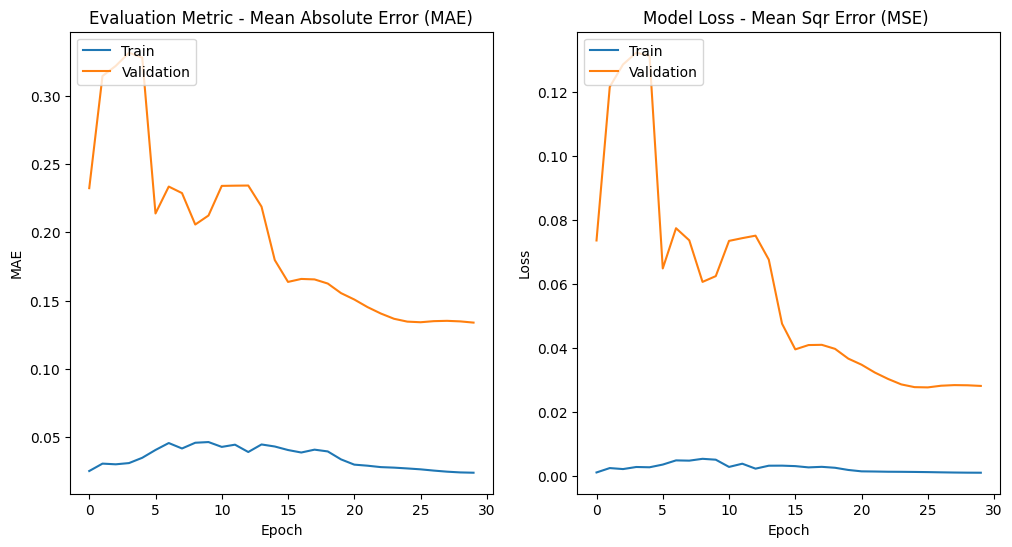

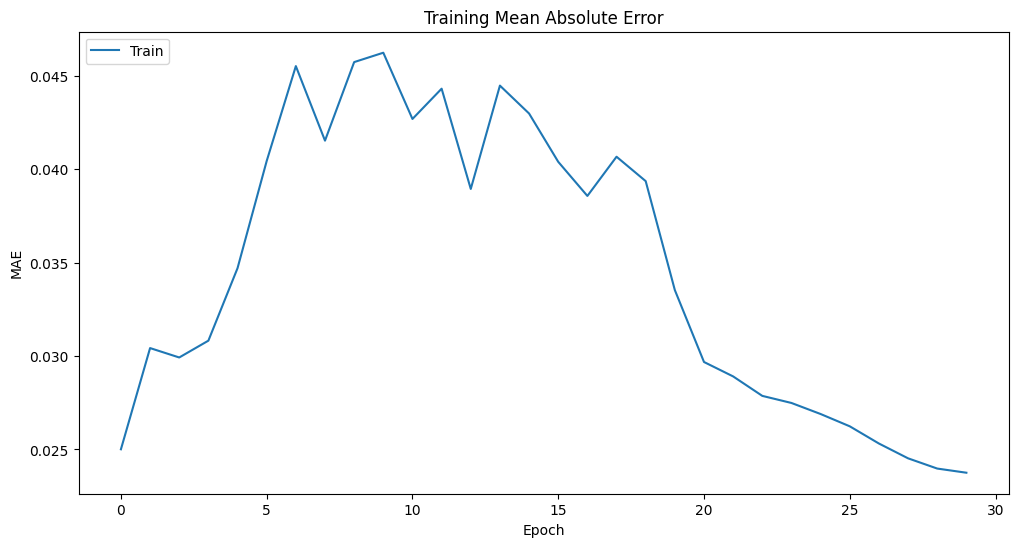

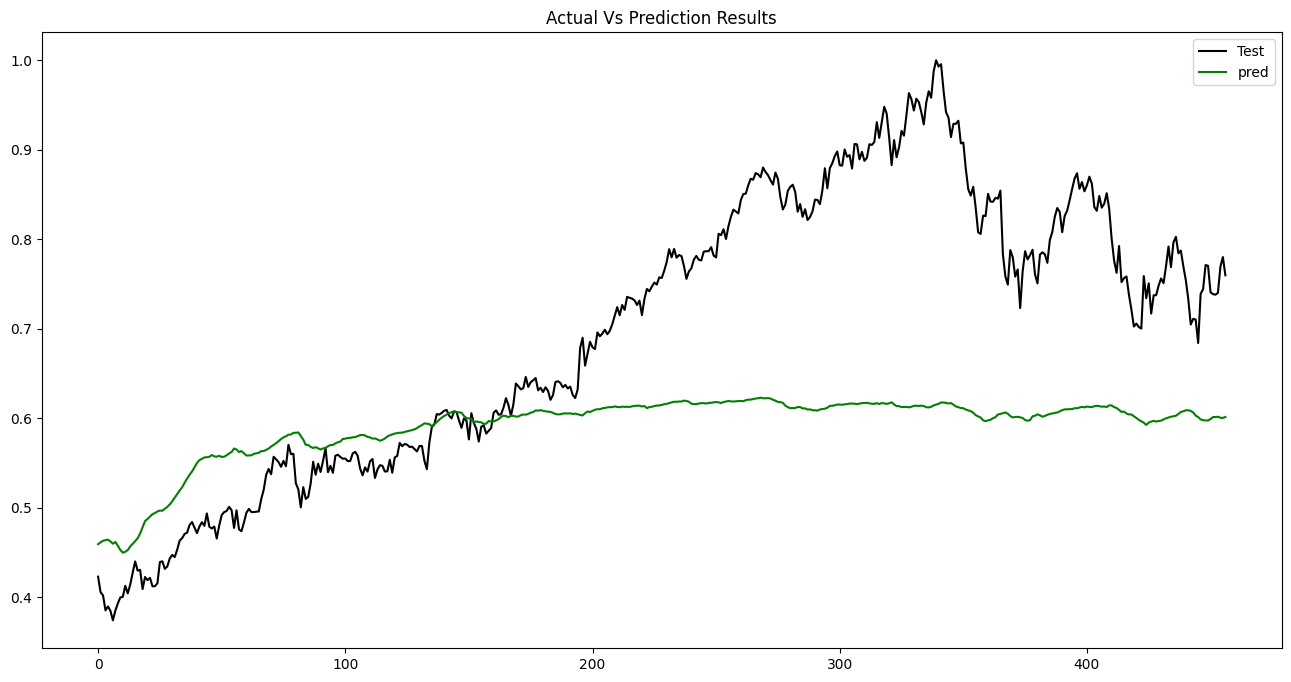

############################################################################
  Model Setup:
                    Name: MSI_F10_L4
             LSTM_Layers: 4
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.15632237417365066
             mean_sqr_err =0.037220471746215934
        root_mean_sqr_err =0.19292607845031198
           pred_diff_mean =0.8552847419698281
      pred_diff_bias_mean =0.14471525803017188
    pred_correctness_mean =0.48577680525164113
                      AIC =-1421.9396334639173



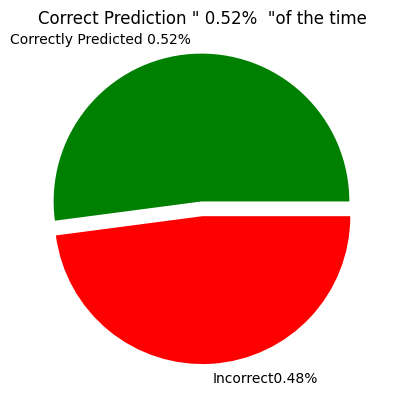

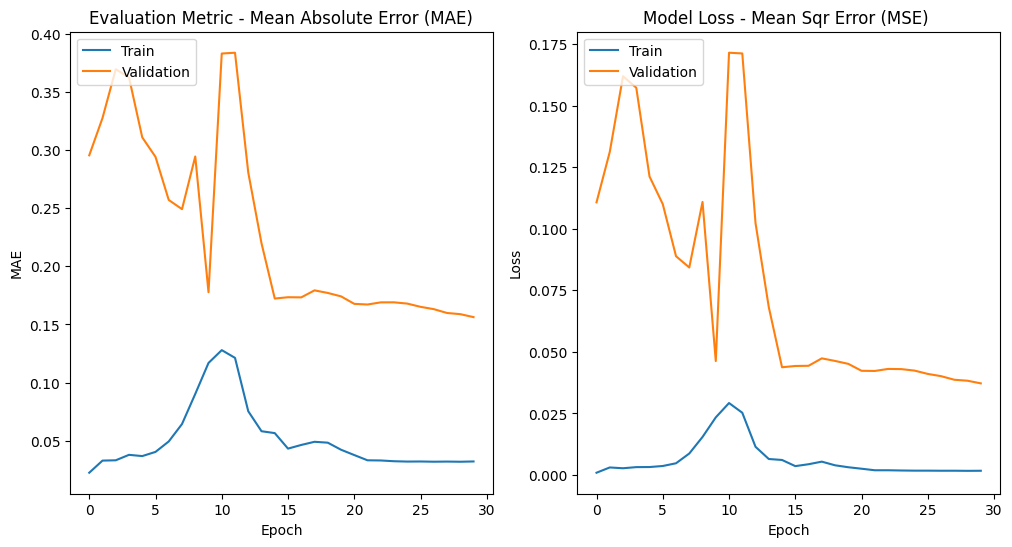

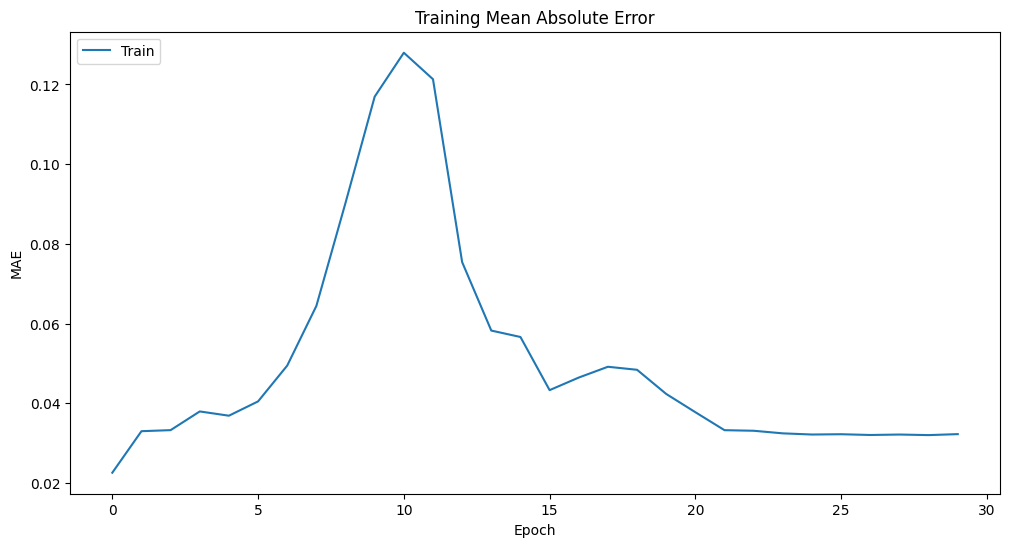

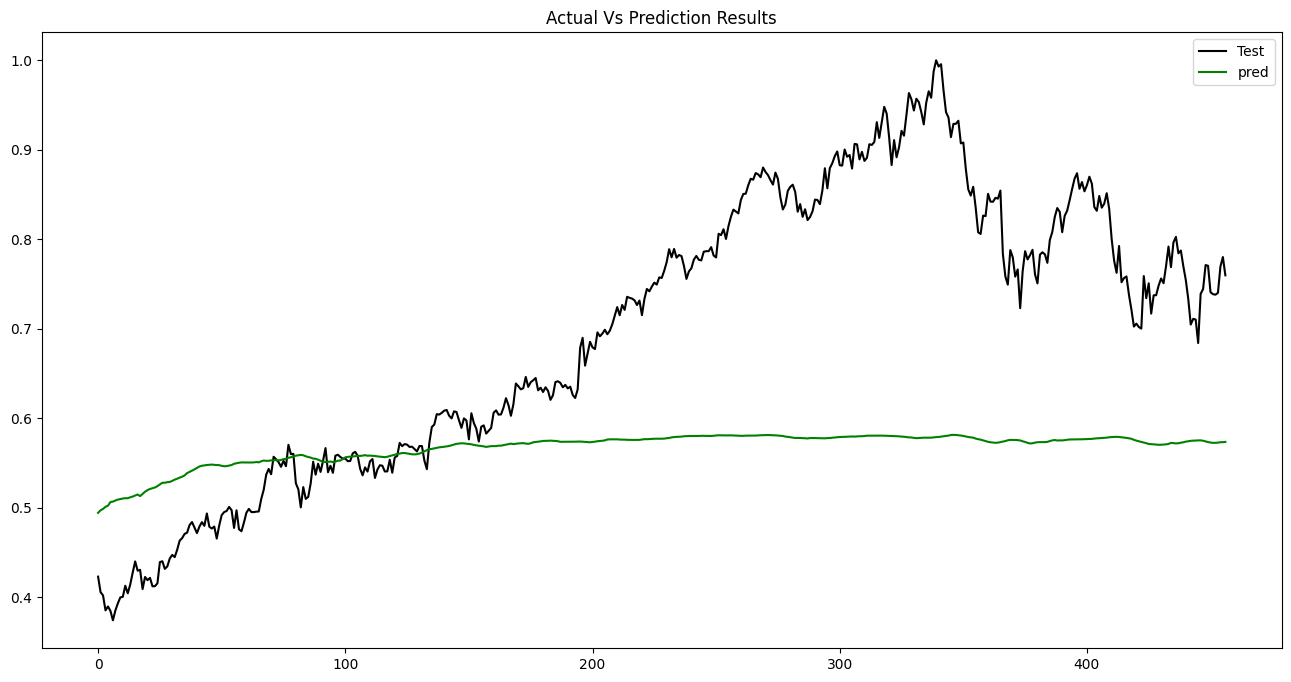

############################################################################
  Model Setup:
                    Name: MSI_F10_L5
             LSTM_Layers: 5
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 10
  Result Data:
             mean_abs_err =0.20260836693211523
             mean_sqr_err =0.058873192045416724
        root_mean_sqr_err =0.24263798557813804
           pred_diff_mean =0.7776327613390632
      pred_diff_bias_mean =0.22236723866093663
    pred_correctness_mean =0.4135667396061269
                      AIC =-1212.3928320121522



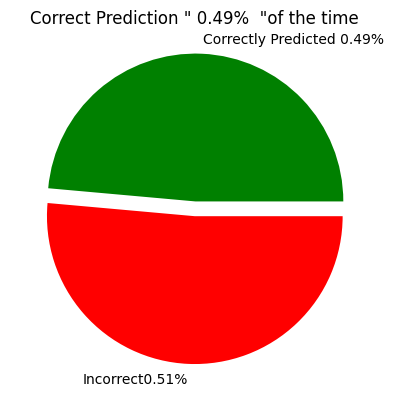

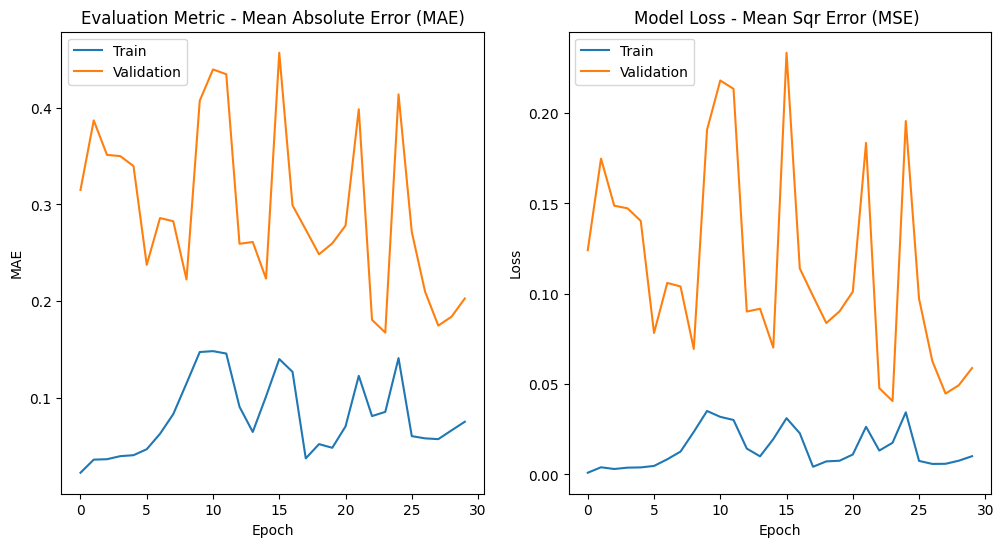

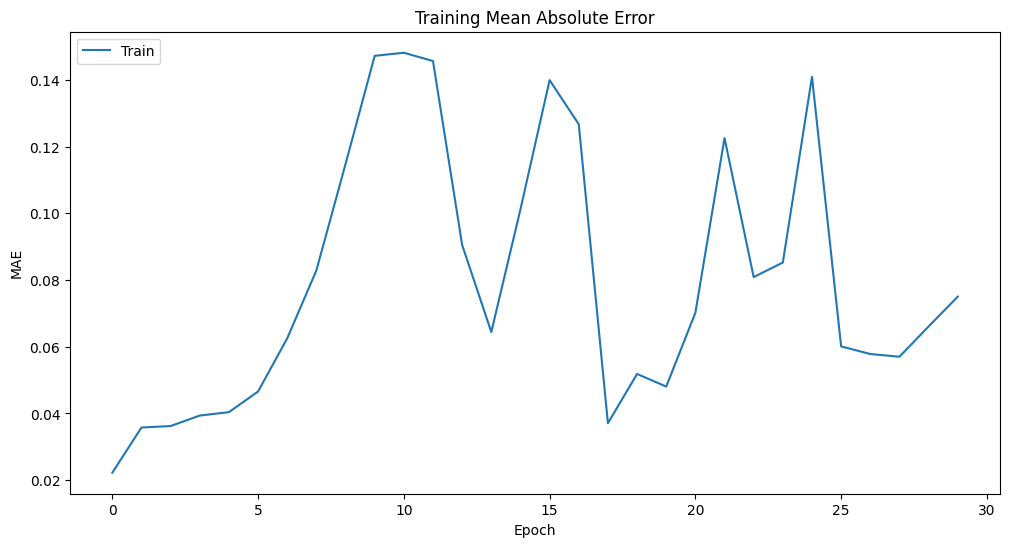

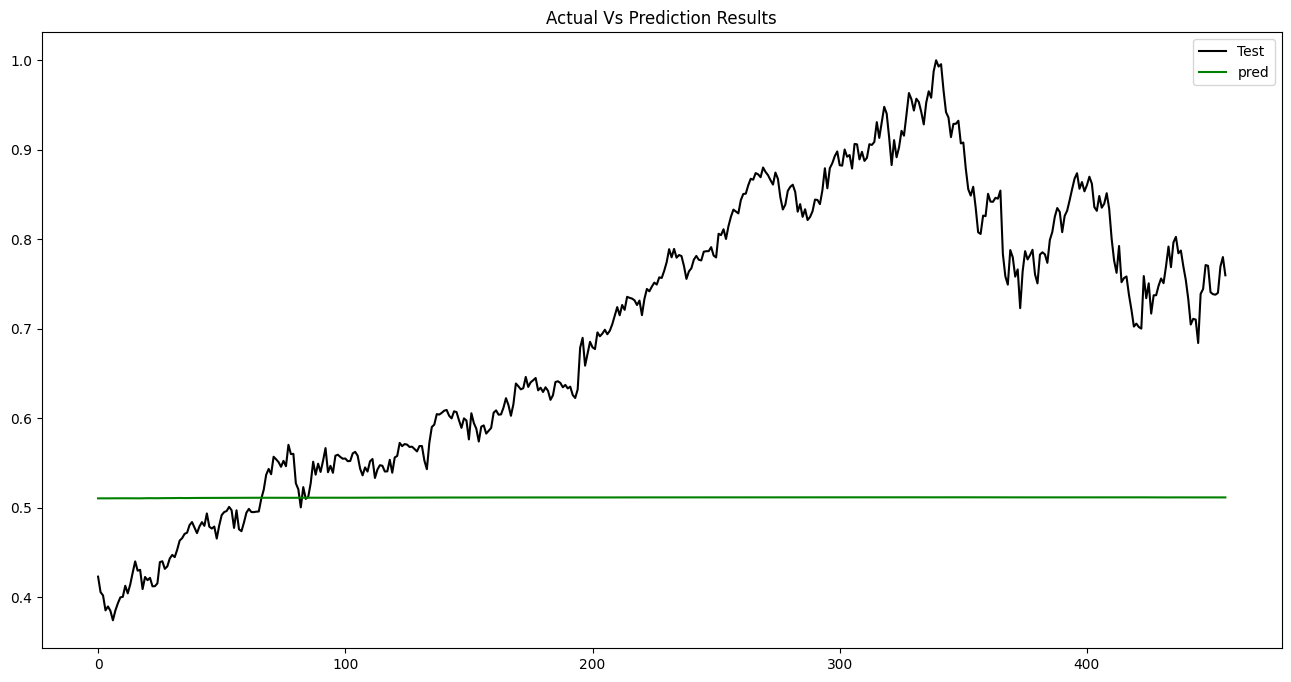

############################################################################
  Model Setup:
                    Name: MSI_F25_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.09123561879532946
             mean_sqr_err =0.013640273796630067
        root_mean_sqr_err =0.11679158273022104
           pred_diff_mean =0.9223482245359911
      pred_diff_bias_mean =0.07765177546400893
    pred_correctness_mean =0.6167400881057269
                      AIC =-1867.8067633805092



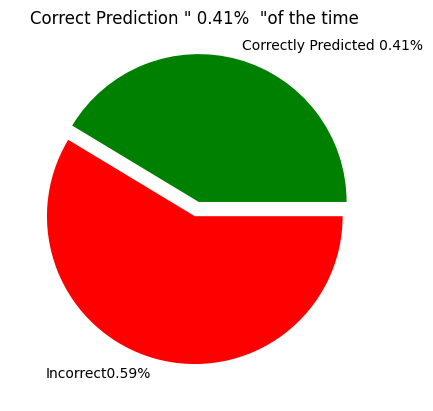

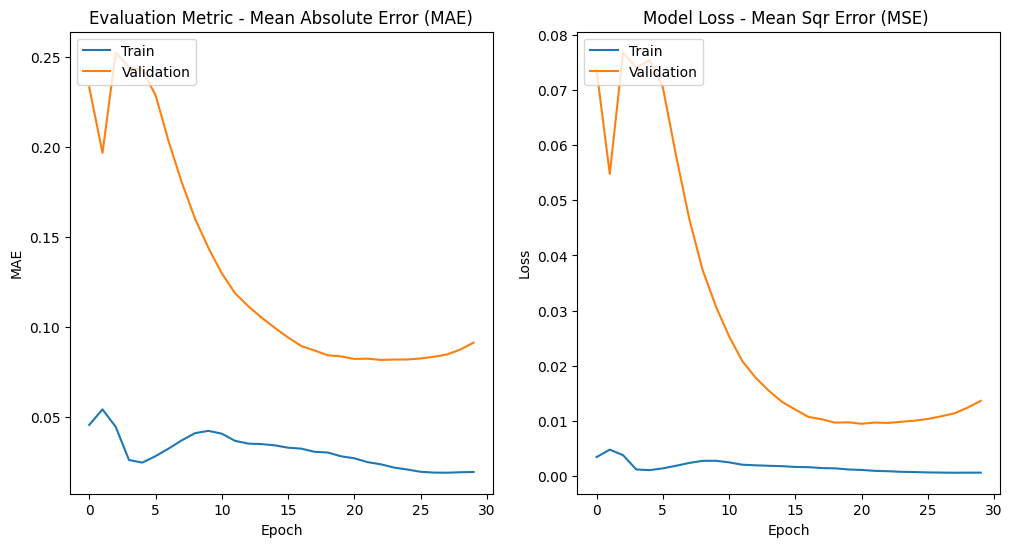

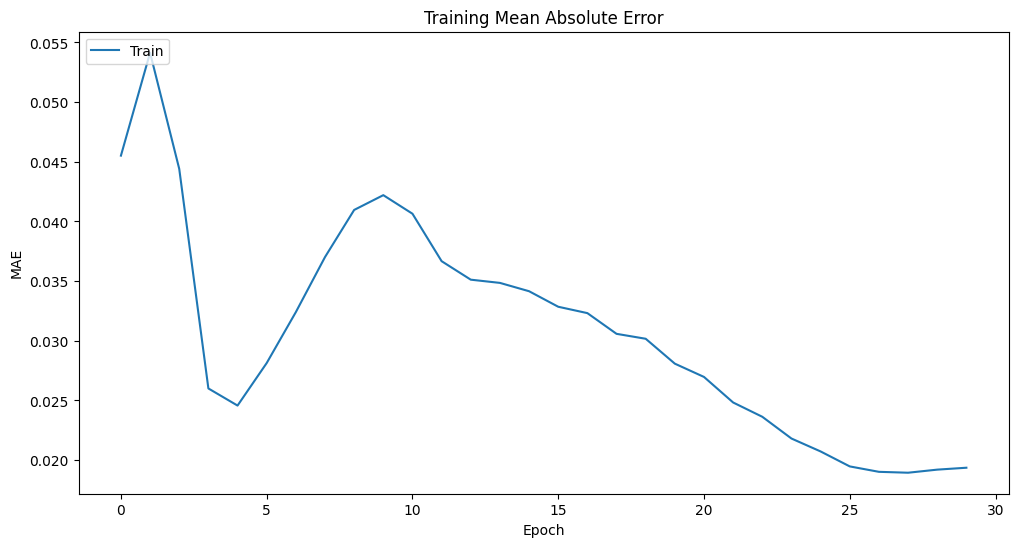

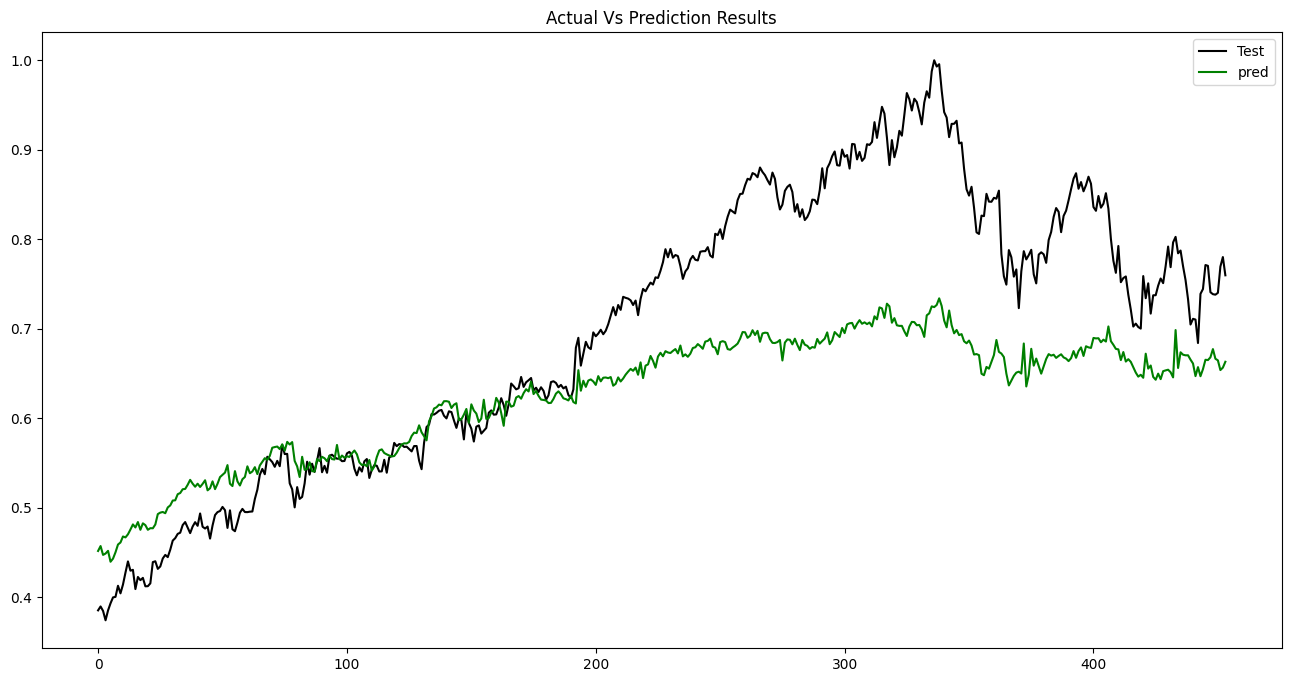

############################################################################
  Model Setup:
                    Name: MSI_F25_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.13544511618174465
             mean_sqr_err =0.029085323448737804
        root_mean_sqr_err =0.17054419793337386
           pred_diff_mean =0.871505391657312
      pred_diff_bias_mean =0.12849460834268797
    pred_correctness_mean =0.539647577092511
                      AIC =-1524.0347977158751



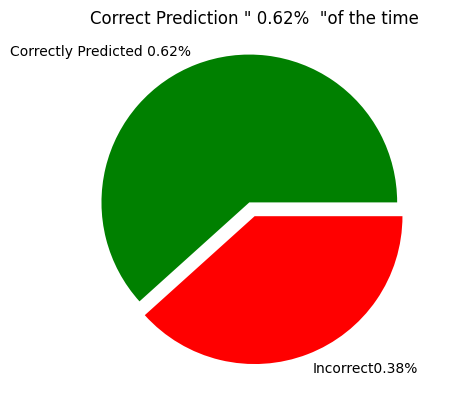

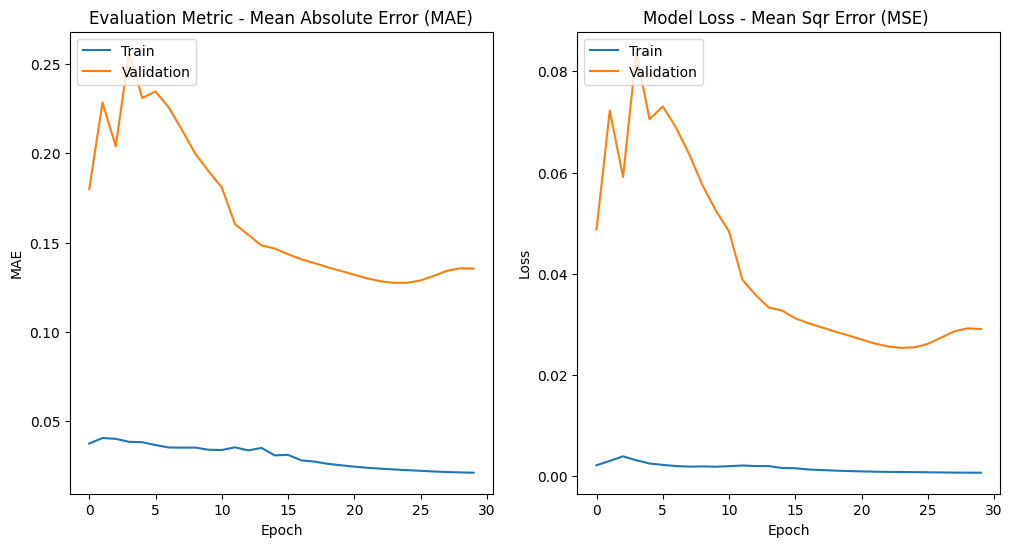

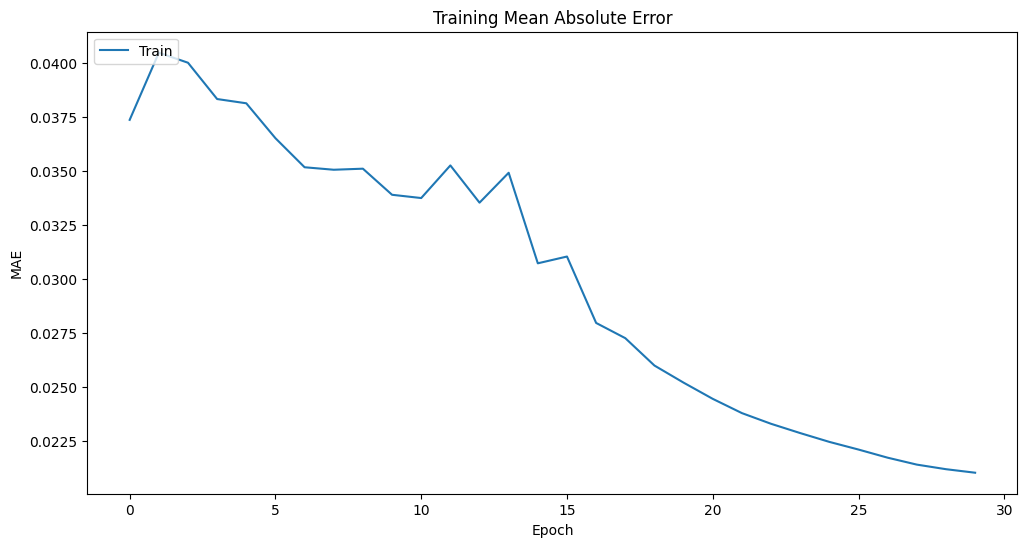

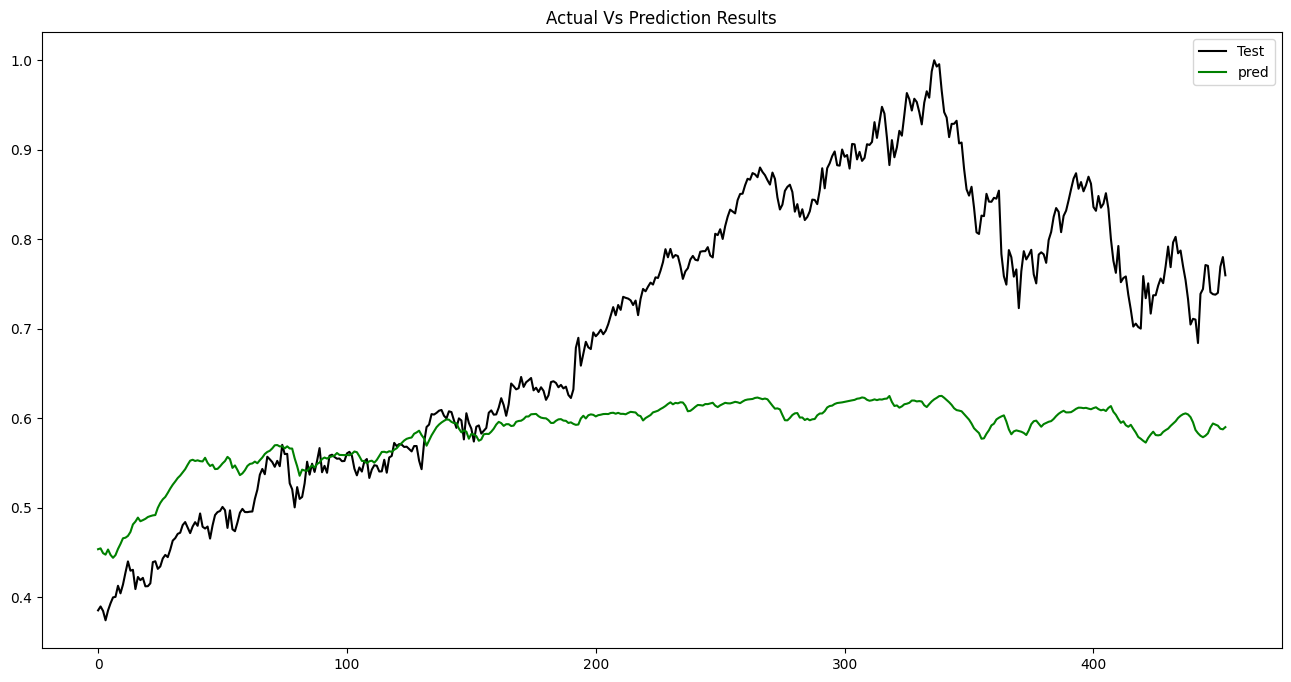

############################################################################
  Model Setup:
                    Name: MSI_F25_L3
             LSTM_Layers: 3
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.42378192851082275
             mean_sqr_err =0.20388174604528586
        root_mean_sqr_err =0.4515326633204799
           pred_diff_mean =0.41579950061540044
      pred_diff_bias_mean =0.5842004993845995
    pred_correctness_mean =0.2422907488986784
                      AIC =-639.9576687765438



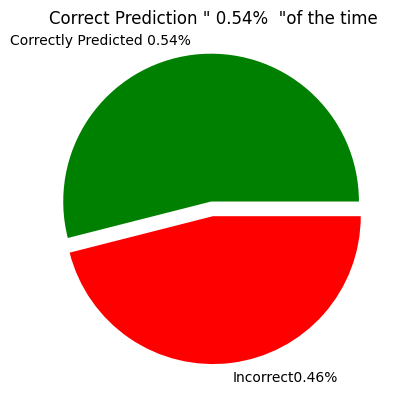

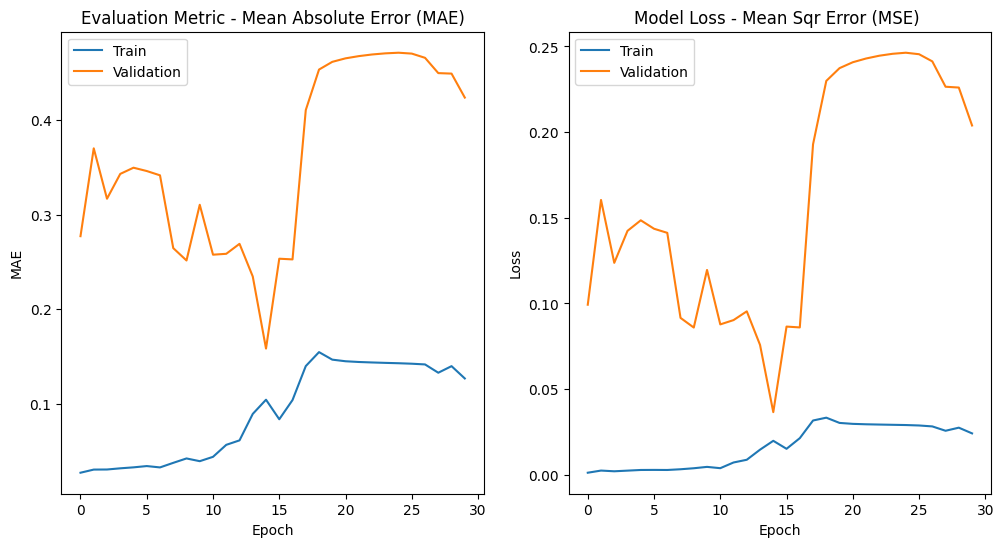

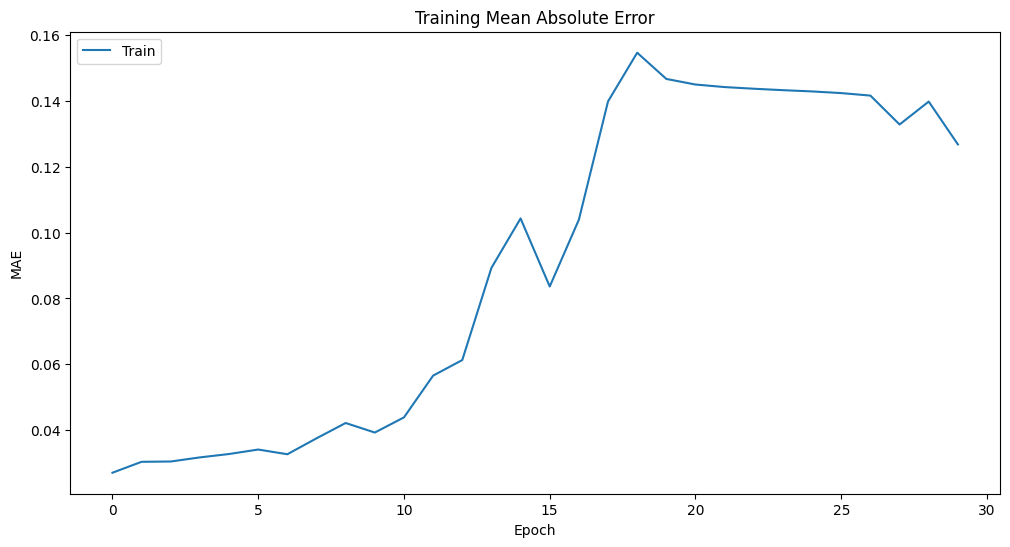

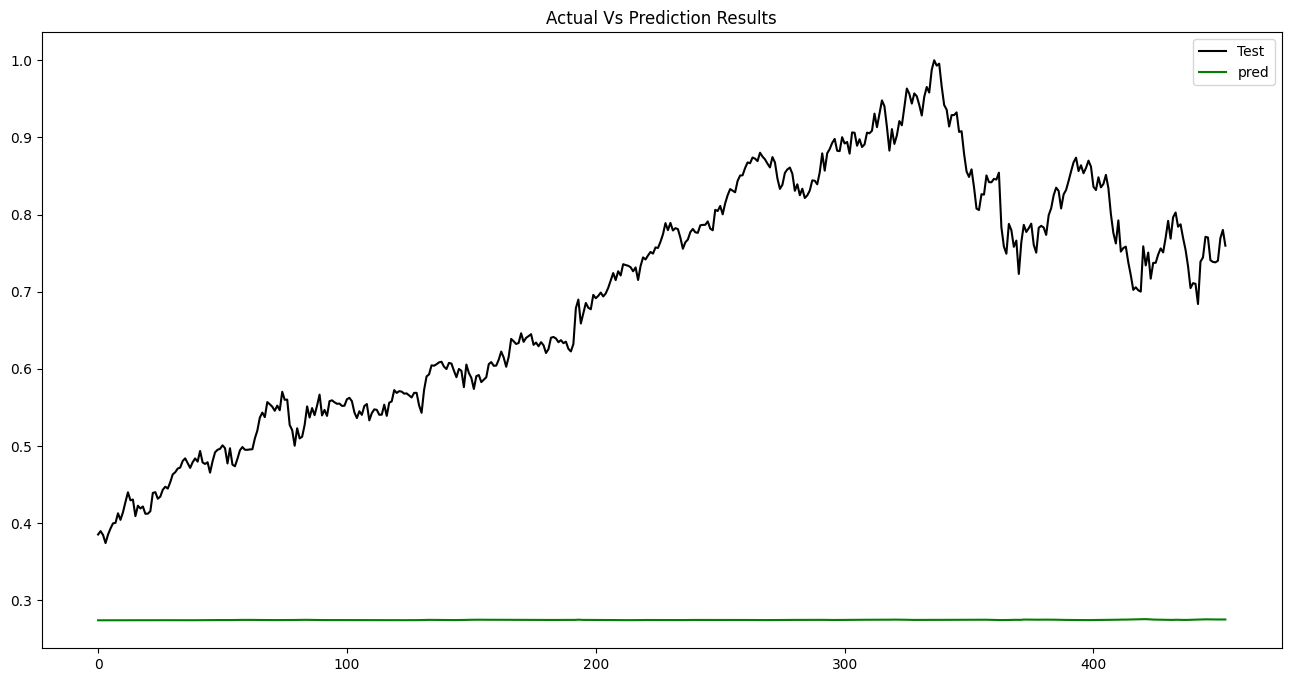

############################################################################
  Model Setup:
                    Name: MSI_F25_L4
             LSTM_Layers: 4
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.46120779068476236
             mean_sqr_err =0.236928974041816
        root_mean_sqr_err =0.48675350439603
           pred_diff_mean =0.35901281006434876
      pred_diff_bias_mean =0.6409871899356513
    pred_correctness_mean =0.2422907488986784
                      AIC =-571.7576711387089



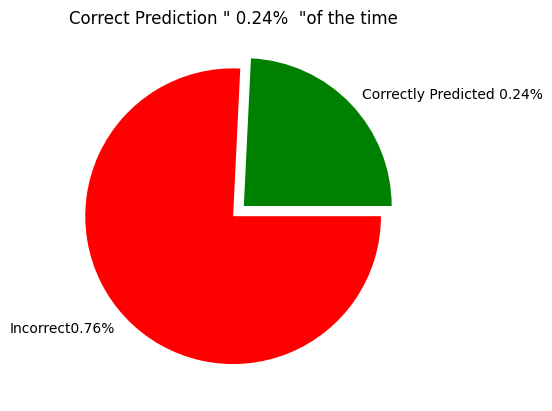

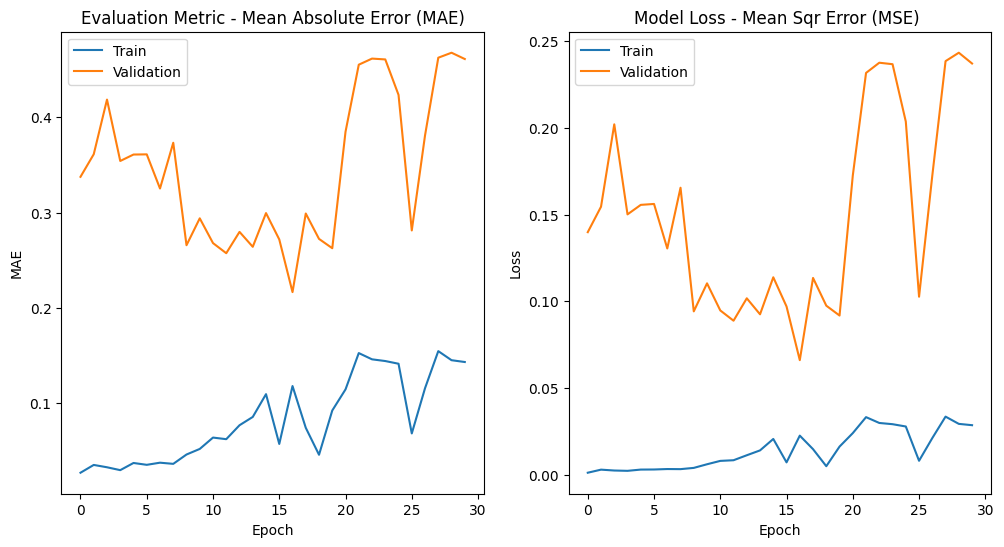

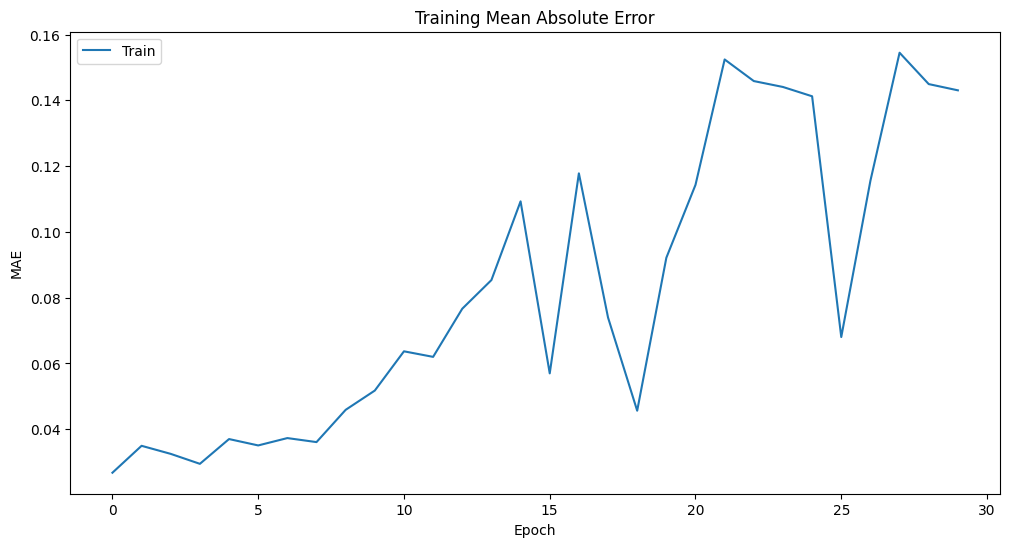

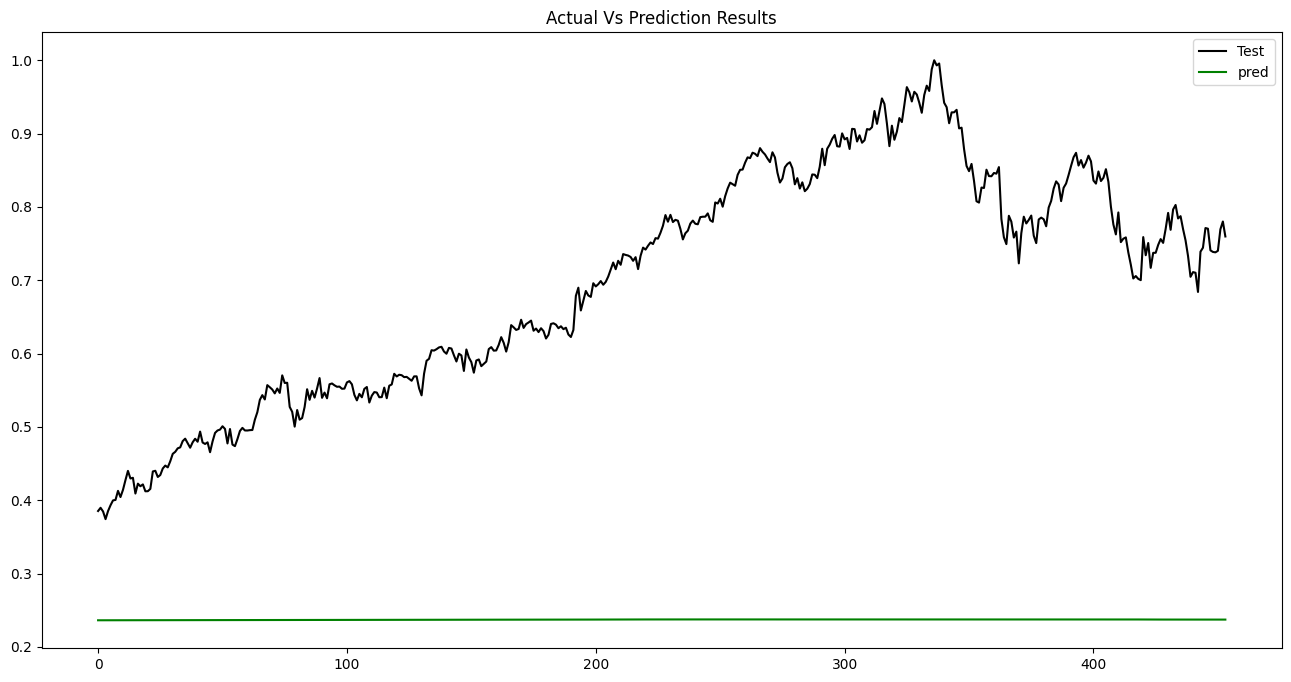

############################################################################
  Model Setup:
                    Name: MSI_F25_L5
             LSTM_Layers: 5
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 25
  Result Data:
             mean_abs_err =0.47640865506071284
             mean_sqr_err =0.2512878680964454
        root_mean_sqr_err =0.5012862137506331
           pred_diff_mean =0.33611831461115815
      pred_diff_bias_mean =0.6638816853888417
    pred_correctness_mean =0.2422907488986784
                      AIC =-545.0448749269801



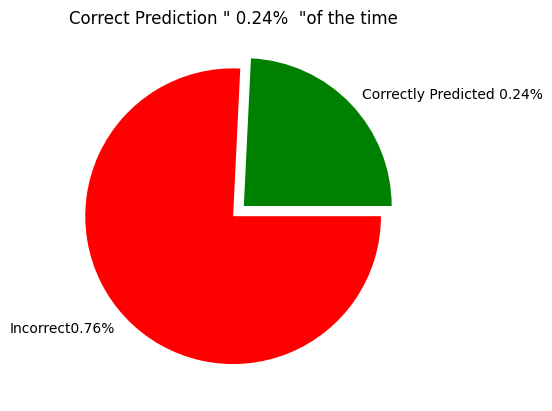

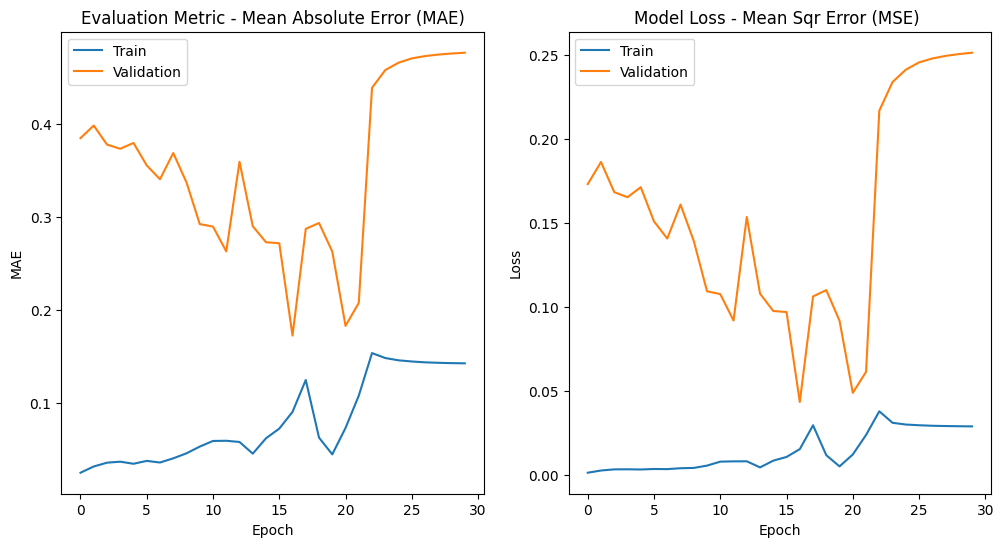

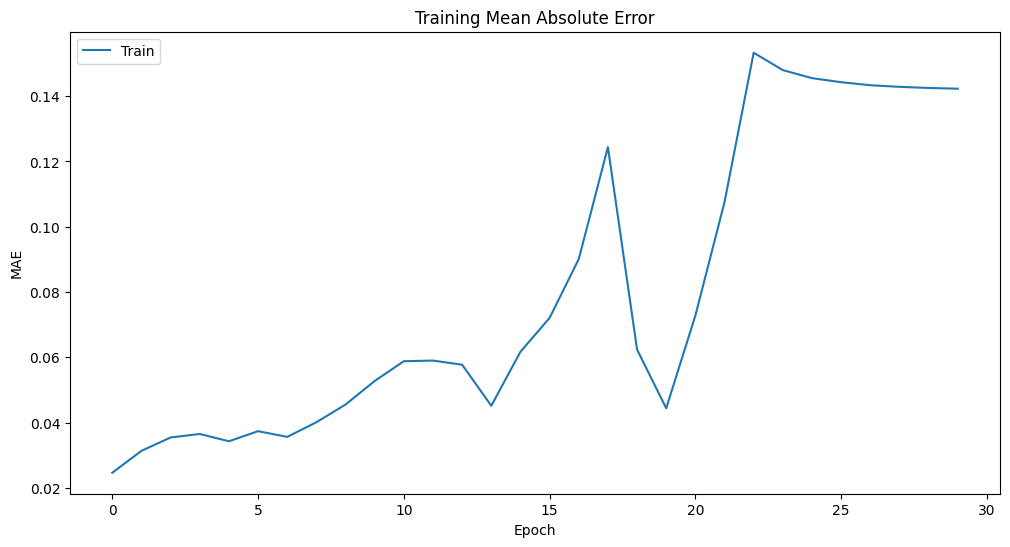

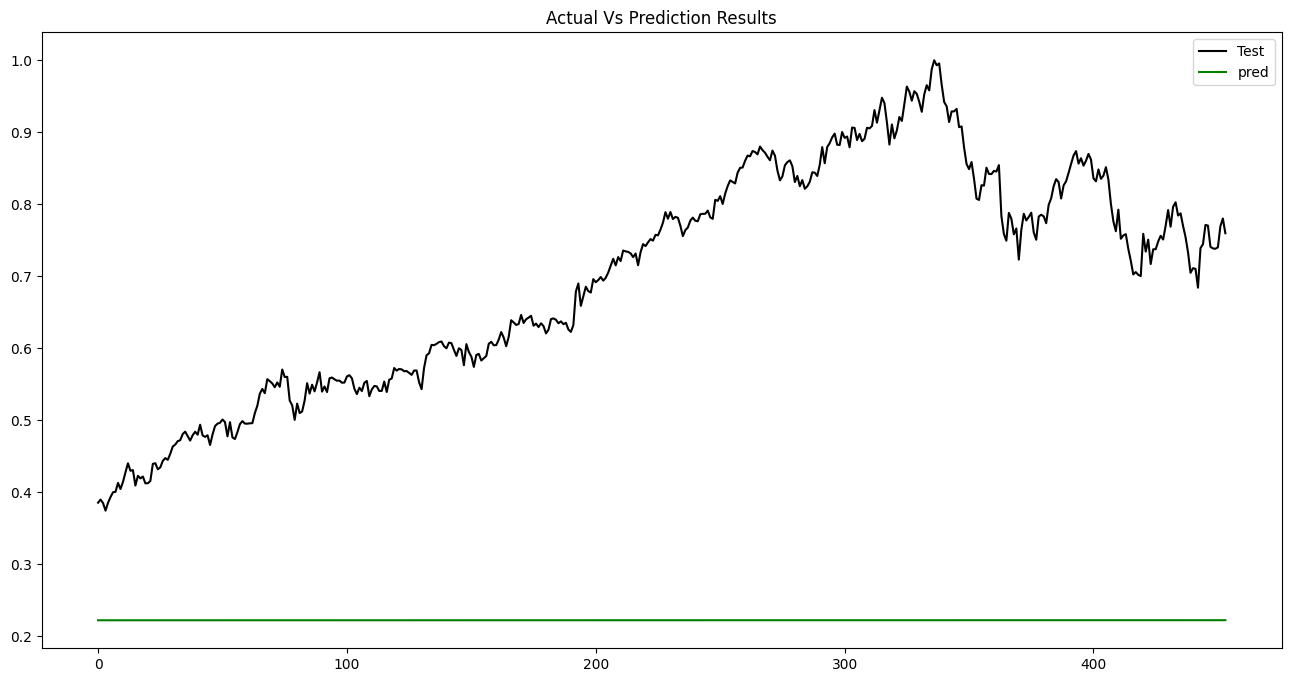

############################################################################
  Model Setup:
                    Name: MSI_F50_L1
             LSTM_Layers: 1
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.09181443176953147
             mean_sqr_err =0.01284738890127215
        root_mean_sqr_err =0.11334632283965876
           pred_diff_mean =0.9379071399046752
      pred_diff_bias_mean =0.06209286009532481
    pred_correctness_mean =0.7527839643652561
                      AIC =-1873.2219942982476



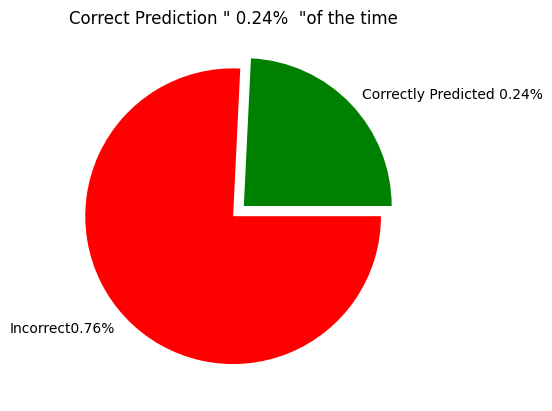

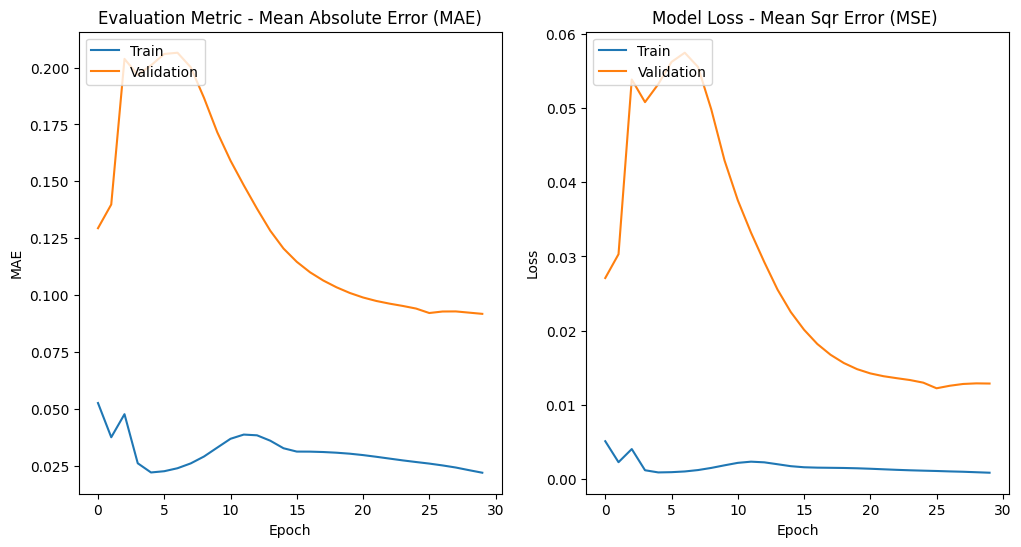

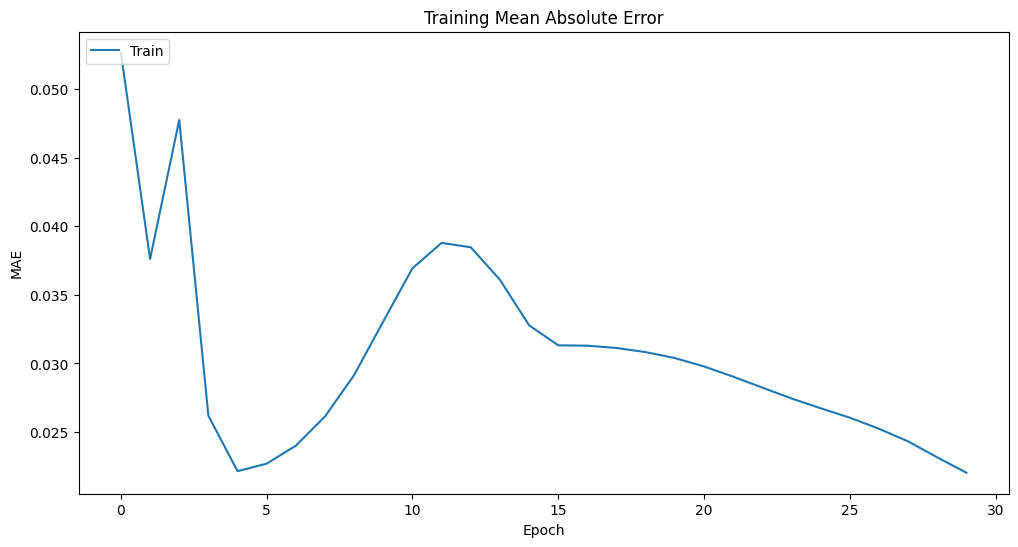

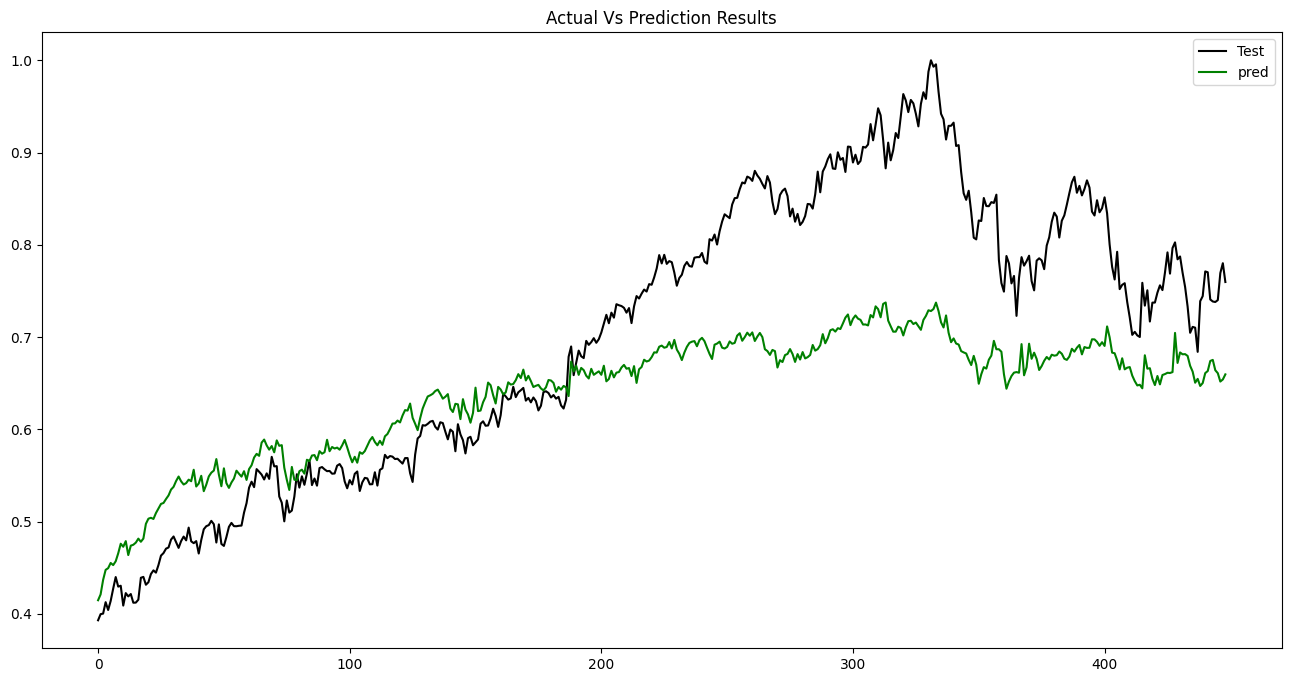

############################################################################
  Model Setup:
                    Name: MSI_F50_L2
             LSTM_Layers: 2
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.12075521164588686
             mean_sqr_err =0.022245171559464726
        root_mean_sqr_err =0.1491481530541519
           pred_diff_mean =0.910844772421764
      pred_diff_bias_mean =0.08915522757823606
    pred_correctness_mean =0.732739420935412
                      AIC =-1626.7280058148833



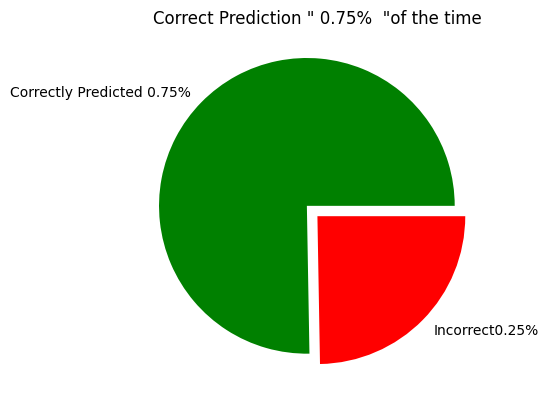

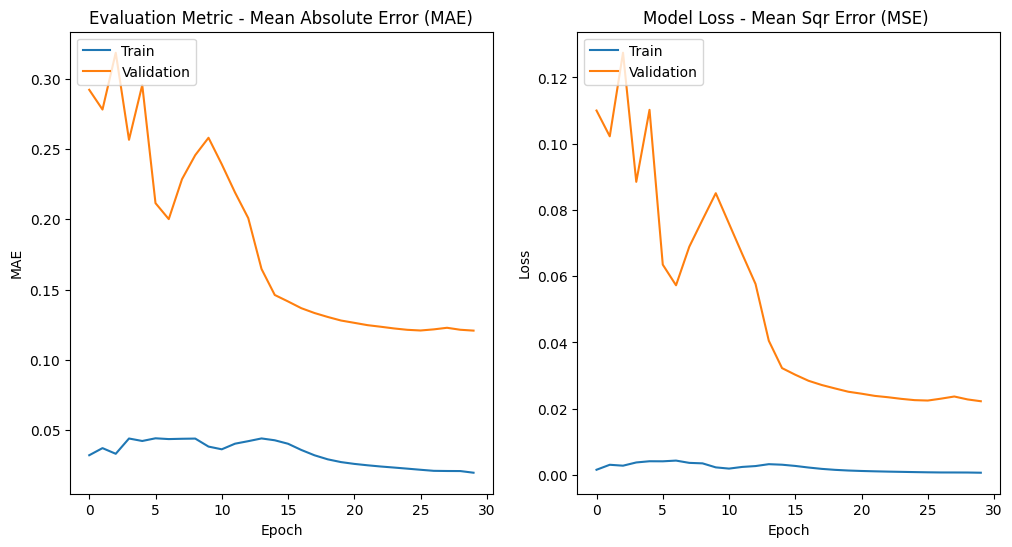

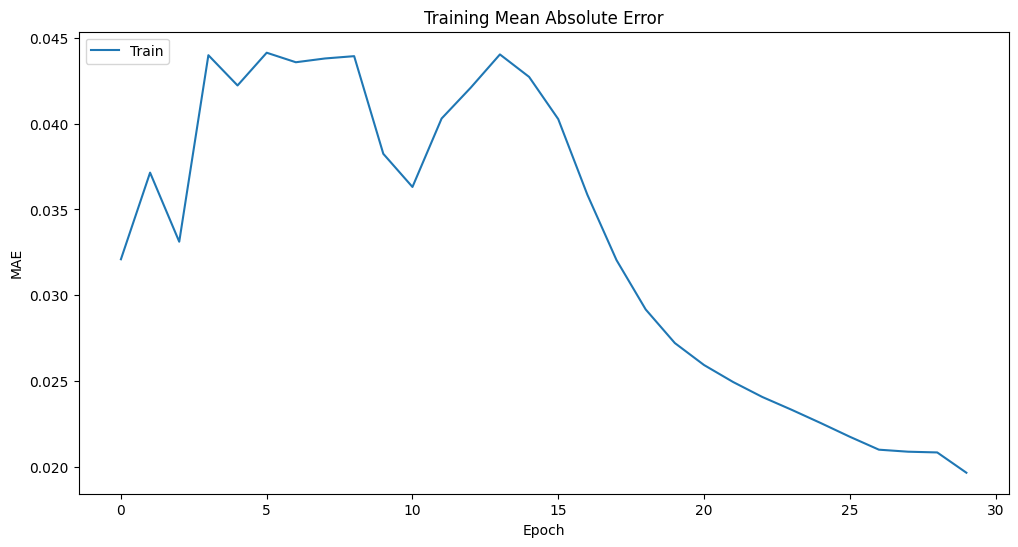

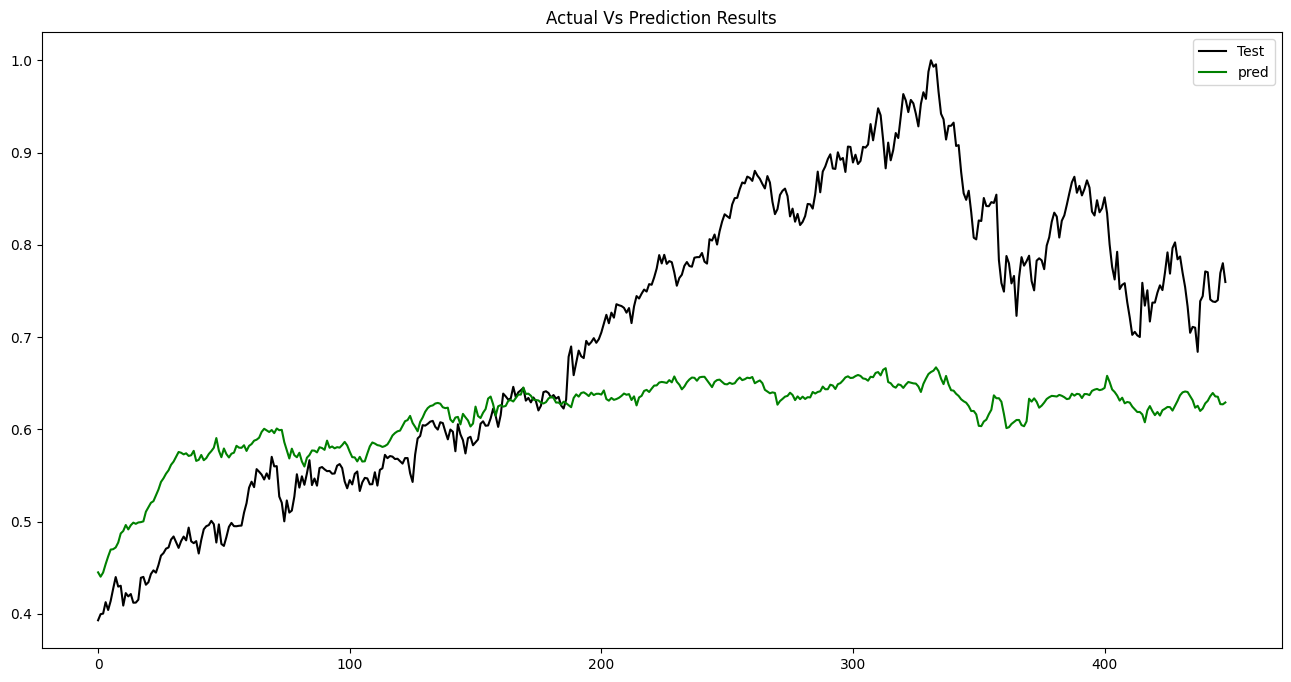

############################################################################
  Model Setup:
                    Name: MSI_F50_L3
             LSTM_Layers: 3
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.19038827902284225
             mean_sqr_err =0.052958884832150985
        root_mean_sqr_err =0.2301279749012514
           pred_diff_mean =0.7934788464657395
      pred_diff_bias_mean =0.20652115353426054
    pred_correctness_mean =0.45879732739420936
                      AIC =-1237.2695015420463



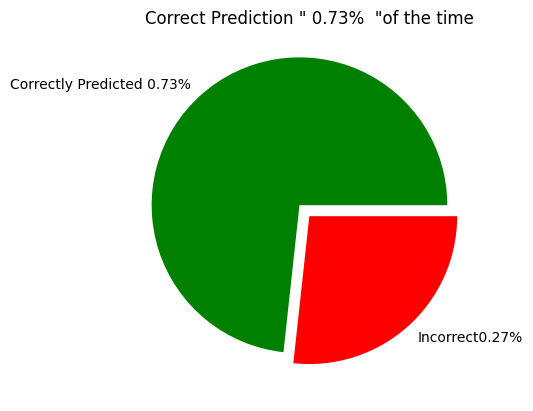

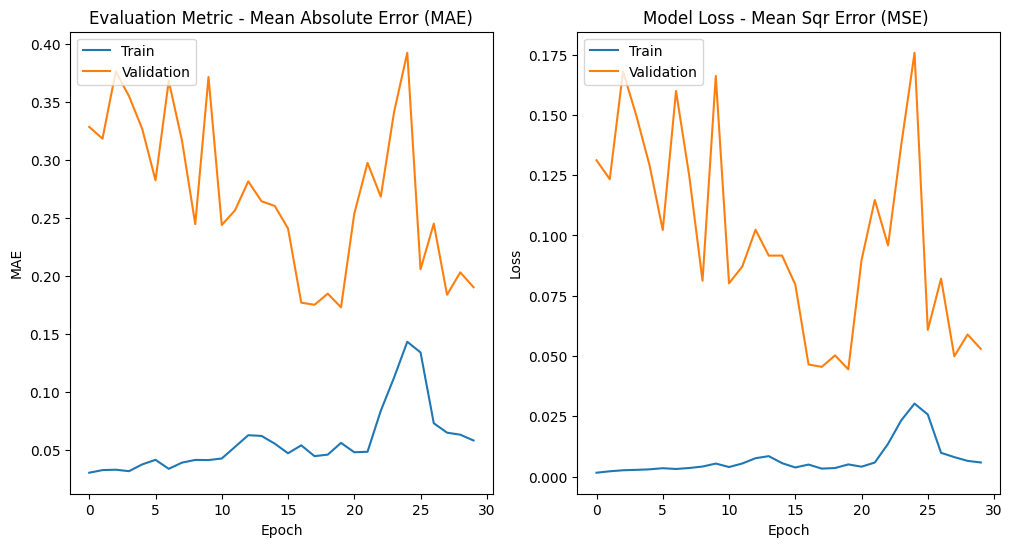

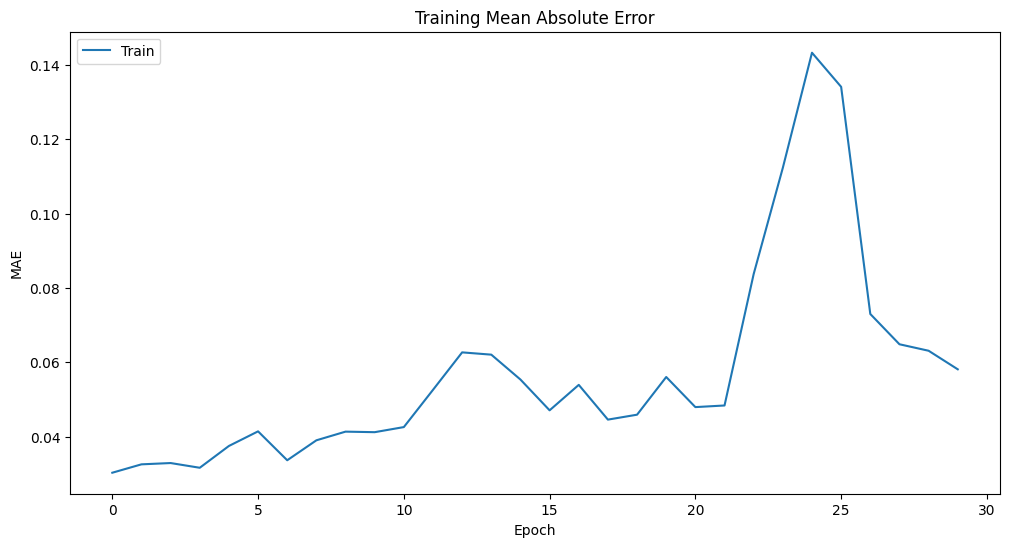

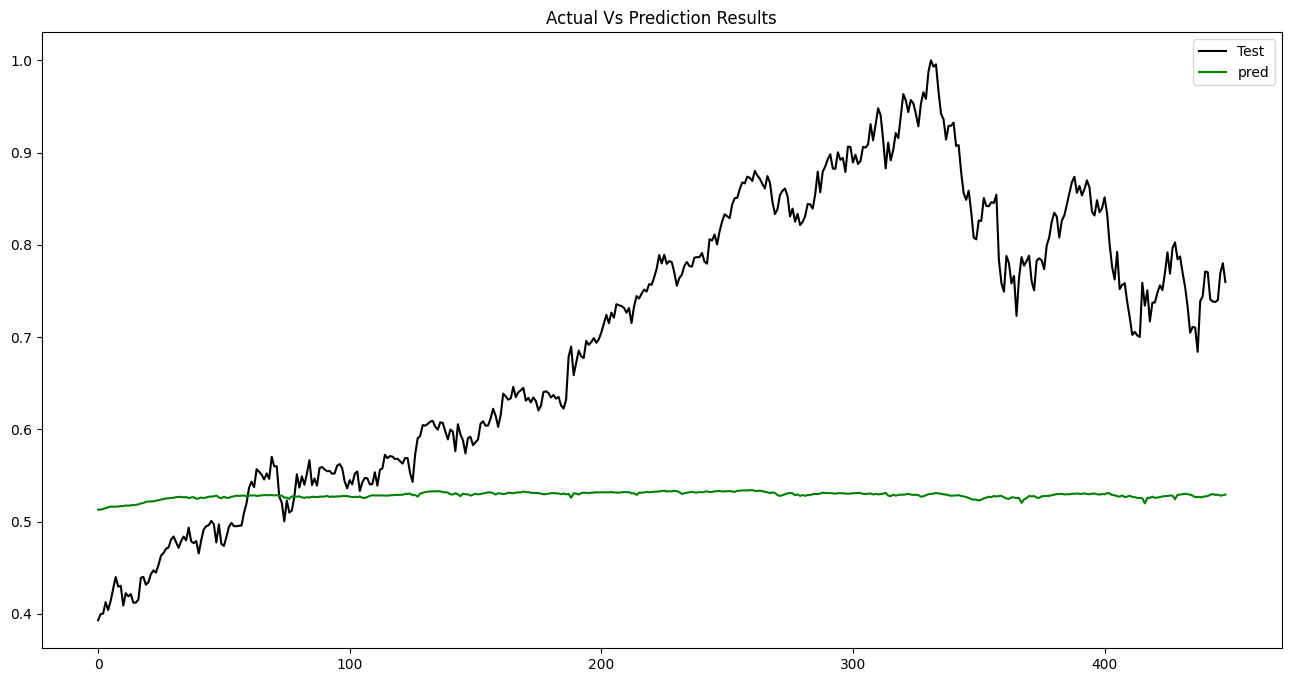

############################################################################
  Model Setup:
                    Name: MSI_F50_L4
             LSTM_Layers: 4
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.4750296660500548
             mean_sqr_err =0.24913887128266626
        root_mean_sqr_err =0.499138128460115
           pred_diff_mean =0.3407655280655798
      pred_diff_bias_mean =0.6592344719344201
    pred_correctness_mean =0.22717149220489977
                      AIC =-541.9954250728589



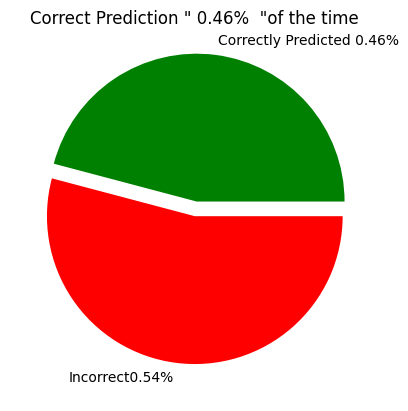

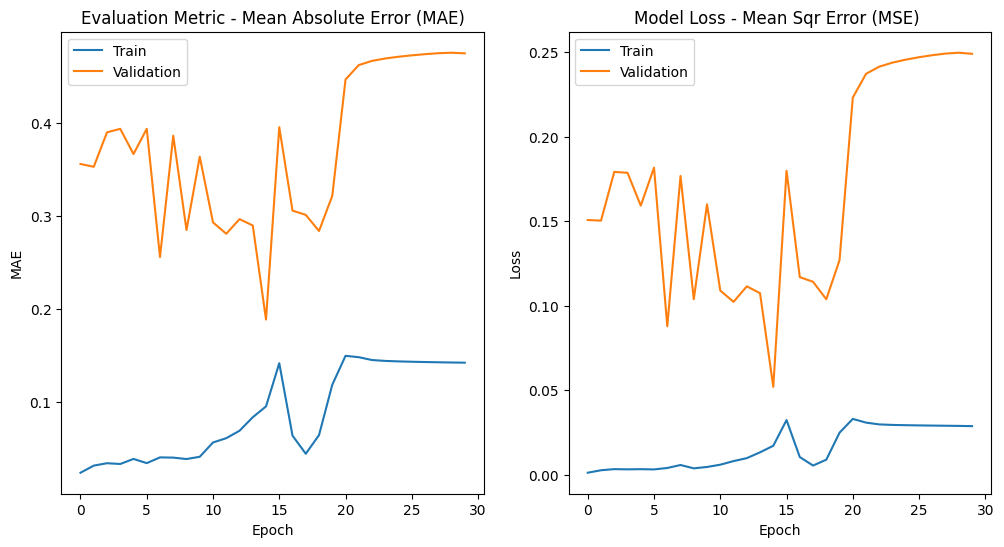

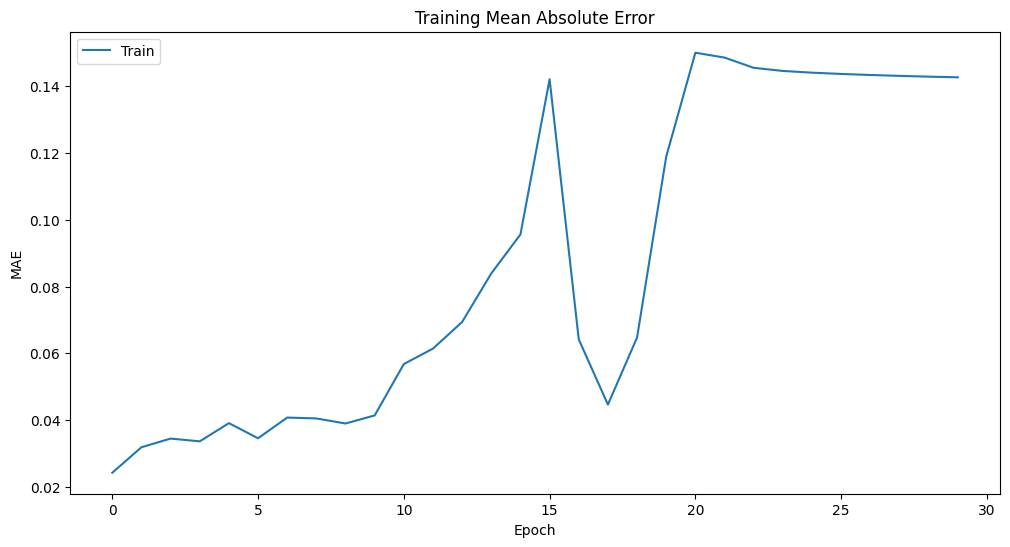

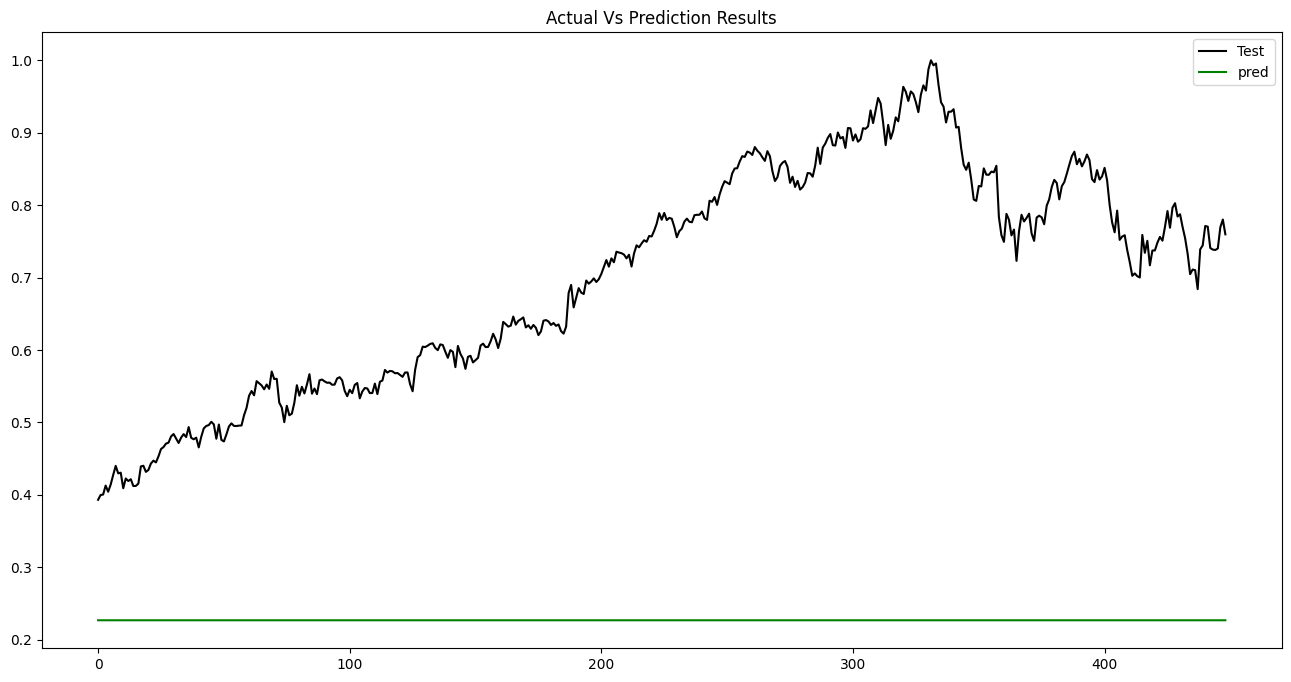

############################################################################
  Model Setup:
                    Name: MSI_F50_L5
             LSTM_Layers: 5
              LSTM_Nodes: 41
               Bach_Size: 15
                  Epochs: 30
  Data Setup:
                  Ticker: MSI
             Indicattors: ^DJI,^BSESN,^BVSP
              Start_Date: 2012-03-11
                End_Date: 2022-07-10
              Frame_Days: 50
  Result Data:
             mean_abs_err =0.46739680555517354
             mean_sqr_err =0.24194549147913302
        root_mean_sqr_err =0.4918795497671488
           pred_diff_mean =0.35223587928233824
      pred_diff_bias_mean =0.6477641207176618
    pred_correctness_mean =0.22717149220489977
                      AIC =-555.1502261880657



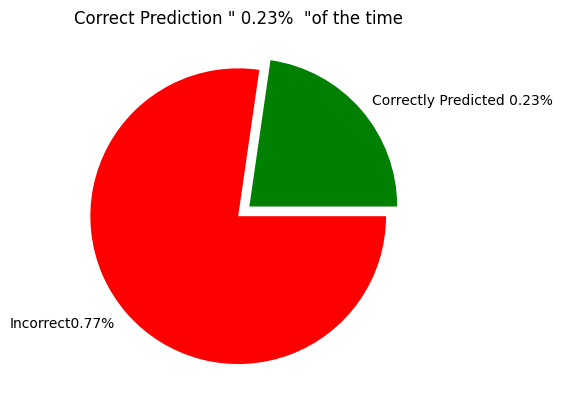

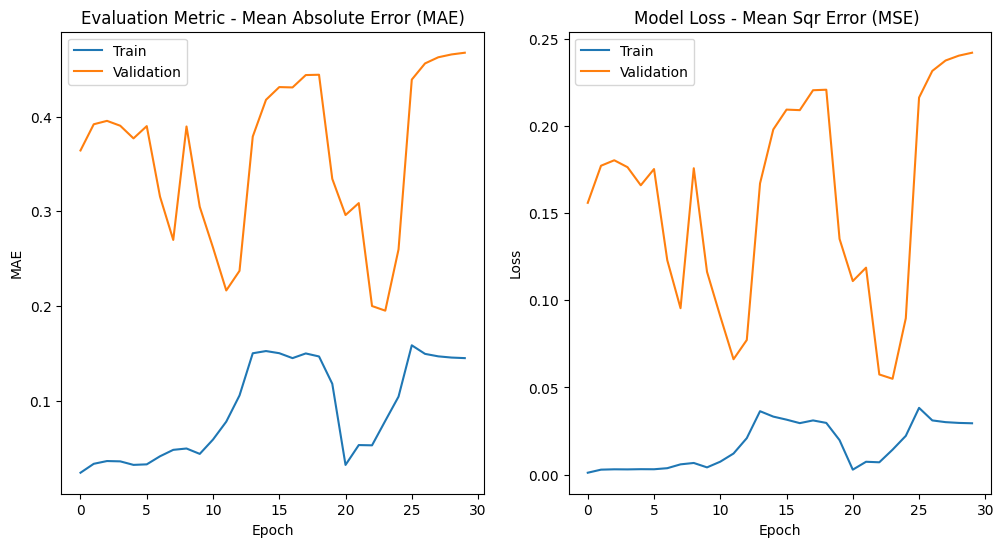

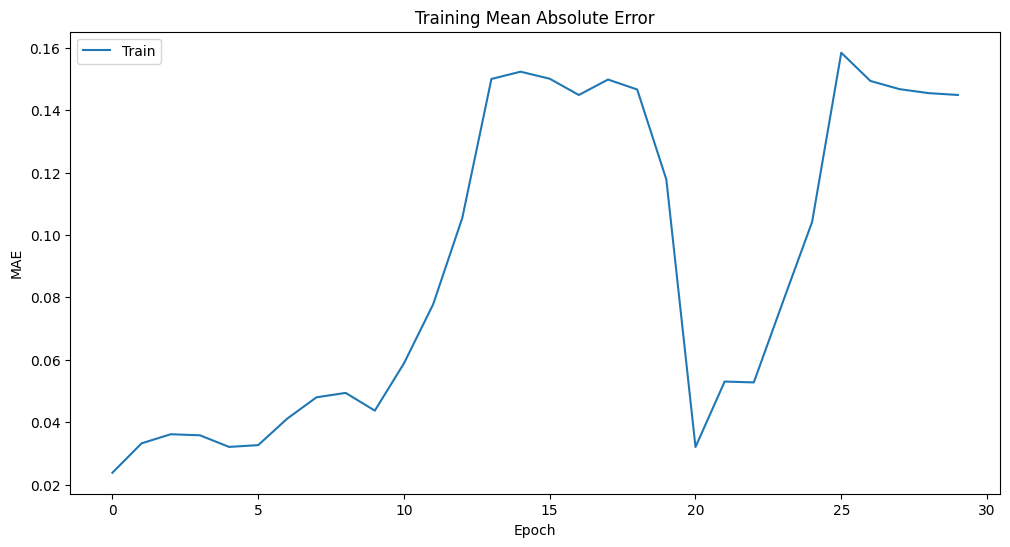

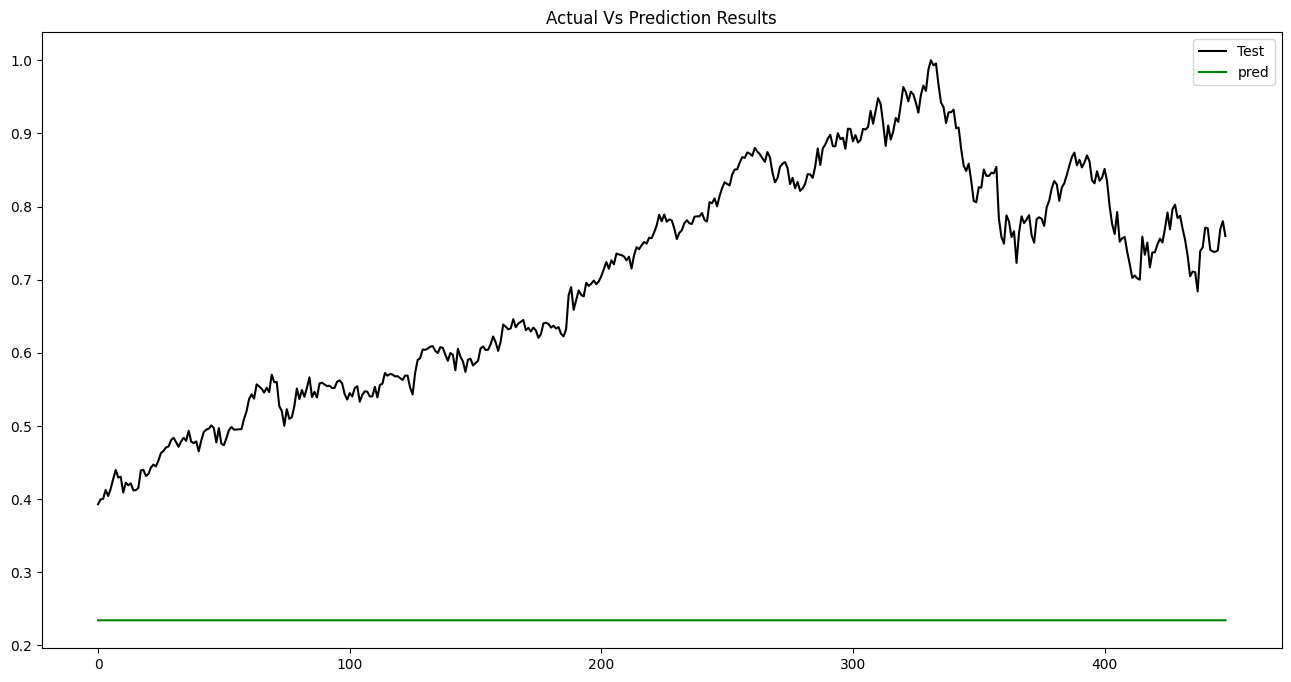

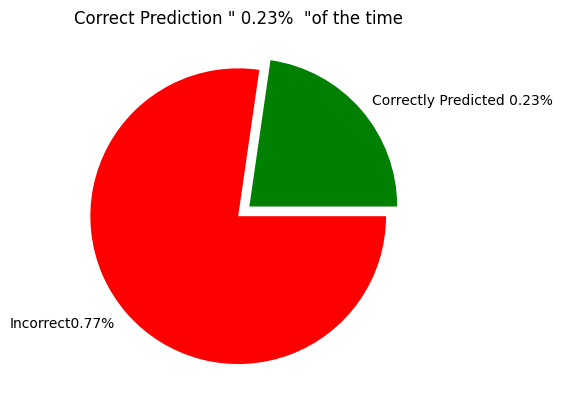

In [20]:
for m in model_list:
  m.View_Performance_Report(show_graphs=True)


#Save Data
##Save Data to Drive

In [21]:
#_ls '/content/drive/MyDrive/Classes/Kent/Machine Learning/Results'

##Save Best Model to drive